In [1]:
# 第一轮目标 -- 熟悉 KFOLD、STACKING、熟悉XGB、LGB、CAT的参数
# 数据清洗：简单均值、删除
# 特征工程：只做数值转化
# 尝试三个模型建模（对比不调参+调参）
# 进行贝叶斯调参，调到最优
# 写KFOLD训练的CLASS，在老师思路的基础上进行优化 
# 进行STACKING，尝试写傻瓜函数
# 提升要求：SMOTE错误修正、使用StratifiedKFold、使用AUC（因为样本不均衡）、accurcy双指标、学习使用XGB、LGB、CAT

# 第二轮目标 -- 熟悉衍生特征
# 参考老师的代码，实现特征的组合，特征的统计，建立属于自己的架子

# 第三轮目标 -- 数据清洗优化
# 参考老师的数据清洗思路，结合之前的参赛代码，进行数据清洗，并且生成属于自己的架子

# 第四轮目标 -- 特征工程（扩展部分）
# 在有时间、有机会的情况下，请教老师、助教、同学，如何构建新的关键特征。这是个玄学


# 调包区、自写代码区

In [509]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,KFold
from sklearn.naive_bayes import BernoulliNB,GaussianNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import SVC,SVR
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier,XGBRegressor
from lightgbm.sklearn import LGBMClassifier,LGBMRegressor
from catboost import CatBoostClassifier,CatBoostRegressor
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score,auc,f1_score,r2_score,mean_squared_error,mean_absolute_error
import pandas as pd
from imblearn.over_sampling import SMOTE
import copy


# 警告忽略
import warnings
warnings.filterwarnings("ignore")

# matplotlib字体设置
plt.rcParams["font.family"] = "Songti SC"
plt.rcParams["axes.unicode_minus"] = False

# matplotlib警告忽略
pd.plotting.register_matplotlib_converters()


# 观看Dataframe长度
pd.set_option('display.max_rows', 10)

# 打开数据

In [571]:
# 打开数据
path = "./input"
df = pd.read_csv(f"{path}/happiness_train_complete.csv",encoding='ISO-8859-1')

# 设置标签（happiness）
df = df.set_index("happiness")

df

id  survey_type  province  city  county      survey_time  gender  \
happiness                                                                       
4             1            1        12    32      59   2015/8/4 14:18       1   
4             2            2        18    52      85  2015/7/21 15:04       1   
4             3            2        29    83     126  2015/7/21 13:24       2   
5             4            2        10    28      51  2015/7/25 17:33       2   
4             5            1         7    18      36   2015/8/10 9:50       2   
...         ...          ...       ...   ...     ...              ...     ...   
2          7996            2        29    82     124  2015/7/21 19:36       1   
3          7997            1        12    32      61  2015/7/31 16:00       2   
4          7998            1        16    46      78   2015/8/1 17:48       2   
3          7999            1         1     1       8  2015/9/22 18:52       2   
4          8000            1         1     1       3  2015/9/28 20:22       2   

           birth  nationality  religion  ...  neighbor_familiarity  \
happiness                                ...                         
4           1959            1         1  ...                     4   
4           1992            1         1  ...                     3   
4           1967            1         0  ...                     4   
5           1943            1         1  ...                     3   
4           1994            1         1  ...                     2   
...          ...          ...       ...  ...                   ...   
2           1981            1         1  ...                     3   
3           1945            1         1  ...                     4   
4           1967            1         1  ...                     4   
3           1978            1         1  ...                     2   
4           1991            1         1  ...                     3   

           public_service_1 public_service_2  public_service_3  \
happiness                                                        
4                        50               60                50   
4                        90               70                70   
4                        90               80                75   
5                       100               90                70   
4                        50               50                50   
...                     ...              ...               ...   
2                        40               50                50   
3                        80               80                80   
4                        75               70                70   
3                        56               67                70   
4                        80               80                80   

           public_service_4  public_service_5  public_service_6  \
happiness                                                         
4                        50              30.0                30   
4                        80              85.0                70   
4                        79              80.0                90   
5                        80              80.0                90   
4                        50              50.0                50   
...                     ...               ...               ...   
2                        50              40.0                50   
3                        80              80.0                60   
4                        80              80.0                70   
3                        69              78.0                60   
4                        80              80.0                80   

           public_service_7  public_service_8  public_service_9  
happiness                                                        
4                        50                50                50  
4                        90                60                60  
4                        90                90        

# 数据检查

In [572]:
# 形状
df.shape


(8000, 139)

In [573]:
# 数据类型
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 4 to 4
Columns: 139 entries, id to public_service_9
dtypes: float64(25), int64(110), object(4)
memory usage: 8.5+ MB


In [34]:
# 缺失值
miss_df = df.isnull().sum()
miss_df[miss_df!=0].sort_values(ascending=False)

edu_other          7997
invest_other       7971
property_other     7934
join_party         7176
s_work_status      5435
s_work_type        5435
work_yr            5049
work_type          5049
work_status        5049
work_manage        5049
edu_yr             1972
marital_now        1770
s_work_exper       1718
s_income           1718
s_edu              1718
s_hukou            1718
s_political        1718
s_birth            1718
edu_status         1120
minor_child        1066
marital_1st         828
social_friend       796
social_neighbor     796
hukou_loc             4
family_income         1
dtype: int64

In [574]:
# 异常值
error_df = df.describe().T
pd.set_option('display.max_rows', None)
error_df.sort_values("min")



count           mean           std     min       25%  \
insur_1               8000.0       1.062125  5.172513e-01    -8.0      1.00   
work_status           2951.0       3.155202  1.759518e+00    -8.0      3.00   
view                  8000.0       3.303500  1.981320e+00    -8.0      3.00   
class_14              8000.0       2.925375  2.315000e+00    -8.0      2.00   
class_10_after        8000.0       4.445125  3.621965e+00    -8.0      4.00   
class_10_before       8000.0       3.439625  2.179266e+00    -8.0      2.00   
class                 8000.0       4.192250  2.040358e+00    -8.0      3.00   
equity                8000.0       3.135125  1.285524e+00    -8.0      2.00   
socia_outing          8000.0       1.825500  1.579355e+00    -8.0      1.00   
status_3_before       8000.0       1.702500  9.761469e-01    -8.0      1.00   
social_friend         7204.0       3.622432  1.992246e+00    -8.0      2.00   
learn                 8000.0       1.926500  1.193430e+00    -8.0      1.00   
relax                 8000.0       3.291000  1.076668e+00    -8.0      3.00   
socialize             8000.0       2.790625  1.083021e+00    -8.0      2.00   
leisure_12            8000.0       3.427375  1.923002e+00    -8.0      1.00   
leisure_11            8000.0       4.482125  1.263083e+00    -8.0      4.00   
leisure_10            8000.0       4.713500  9.945056e-01    -8.0      5.00   
leisure_9             8000.0       3.521500  1.624844e+00    -8.0      2.00   
leisure_8             8000.0       3.591500  1.576607e+00    -8.0      2.00   
social_neighbor       7204.0       3.474181  2.066579e+00    -8.0      2.00   
s_edu                 6282.0       4.614454  3.080985e+00    -8.0      3.00   
work_type             2951.0       0.906811  1.404517e+00    -8.0      1.00   
status_peer           8000.0       2.226125  9.715248e-01    -8.0      2.00   
s_political           6282.0       1.319007  1.051660e+00    -8.0      1.00   
minor_child           6934.0       0.456879  8.249855e-01    -8.0      0.00   
daughter              8000.0       0.767125  9.805684e-01    -8.0      0.00   
son                   8000.0       0.924375  9.515876e-01    -8.0      0.00   
s_hukou               6282.0       1.842566  1.404685e+00    -8.0      1.00   
s_work_status         2565.0       3.175828  1.769002e+00    -8.0      3.00   
s_work_type           2565.0       0.963743  1.213167e+00    -8.0      1.00   
f_edu                 8000.0       2.043500  3.721873e+00    -8.0      1.00   
work_manage           2951.0       2.652321  1.716054e+00    -8.0      2.00   
f_political           8000.0       1.079125  1.733707e+00    -8.0      1.00   
car                   8000.0       1.817125  5.118247e-01    -8.0      2.00   
m_edu                 8000.0       1.550500  3.079673e+00    -8.0      1.00   
family_status         8000.0       2.595875  1.077011e+00    -8.0      2.00   
m_political           8000.0       0.899000  1.317390e+00    -8.0      1.00   
m_work_14             8000.0       4.027500  5.518247e+00    -8.0      2.00   
insur_4               8000.0       1.835625  8.569992e-01    -8.0      2.00   
insur_3               8000.0       1.820875  8.083136e-01    -8.0      2.00   
insur_2               8000.0       1.232875  8.162276e-01    -8.0      1.00   
f_work_14             8000.0       2.744625  4.214010e+00    -8.0      1.00   
leisure_6             8000.0       3.756250  9.375211e-01    -8.0      3.00   
leisure_7             8000.0       3.554000  1.243393e+00    -8.0      3.00   
leisure_4             8000.0       3.762125  1.471754e+00    -8.0      3.00   
trust_6               8000.0       2.020375  4.185588e+00    -8.0      3.00   
trust_7               8000.0       2.622375  2.036061e+00    -8.0      2.00   
trust_8               8000.0       2.228375  3.974474e+00    -8.0      3.00   
leisure_5             8000.0       4.402625  1.423735e+00    -8.0      4.00   
trust_10              8000.0       0.668250  4.735662e+00    -8.0      1.

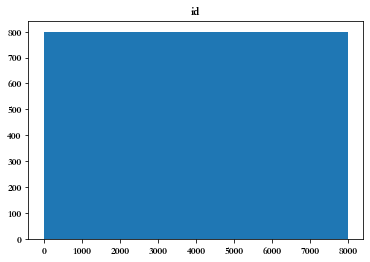

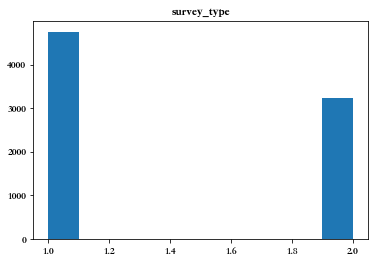

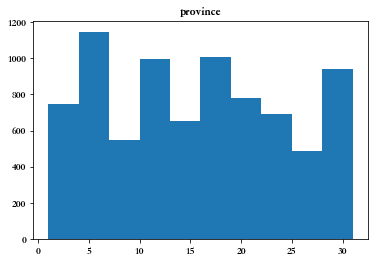

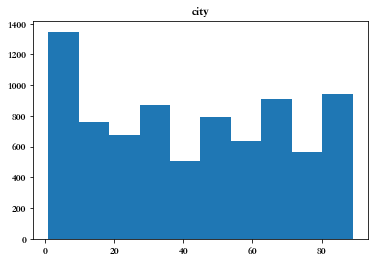

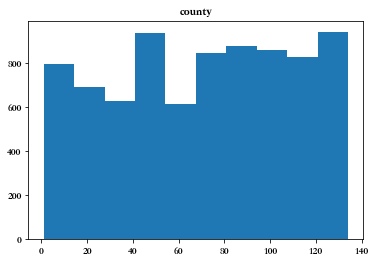

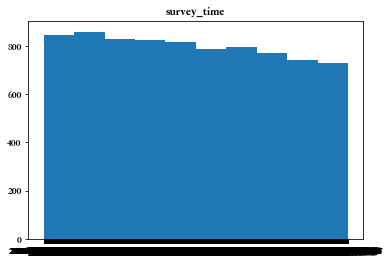

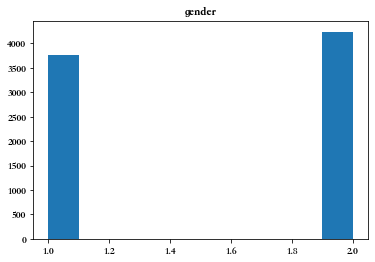

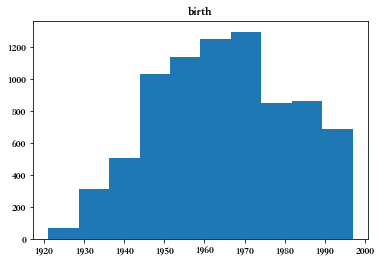

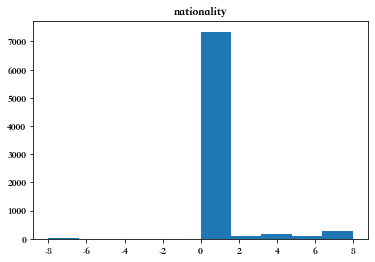

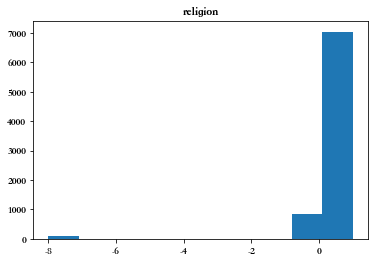

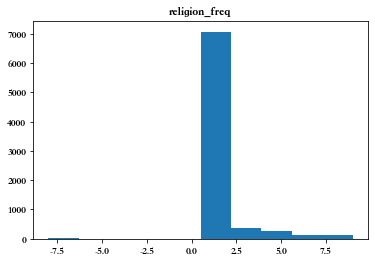

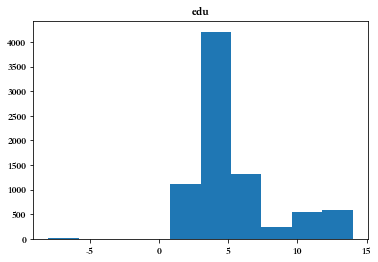

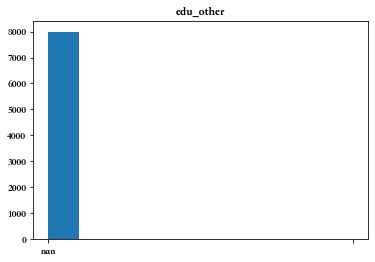

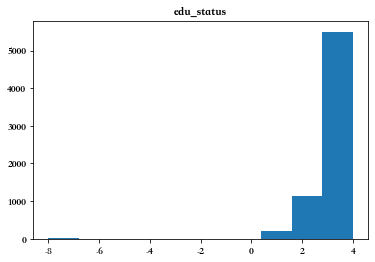

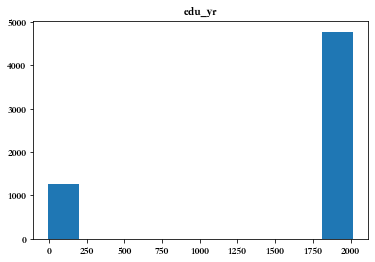

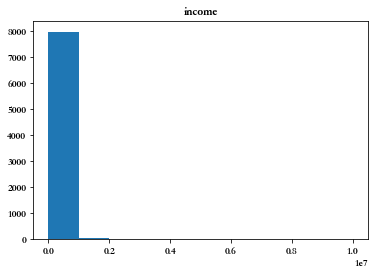

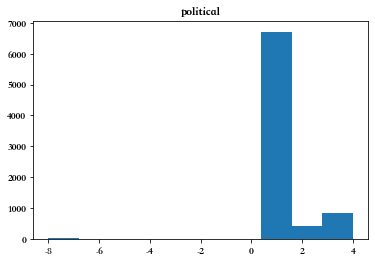

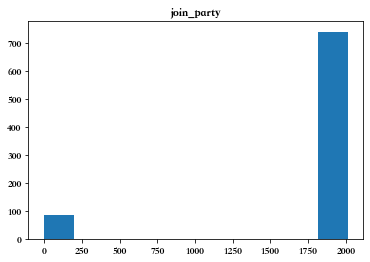

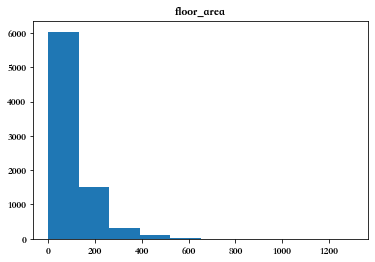

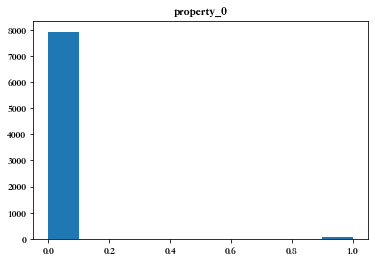

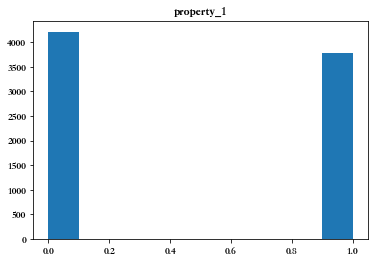

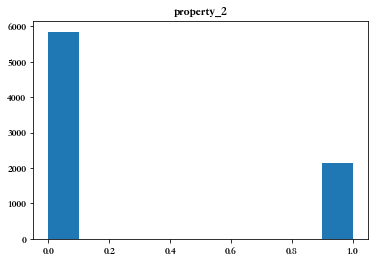

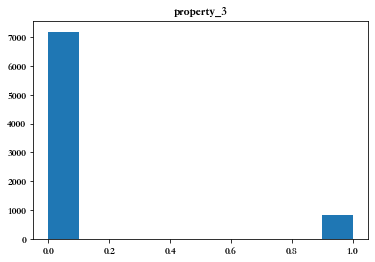

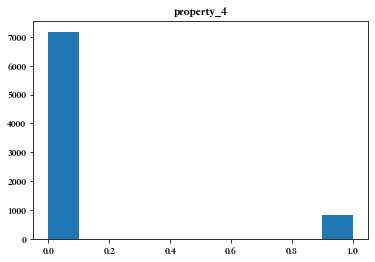

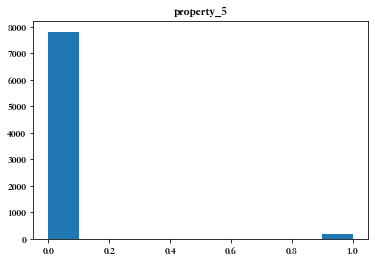

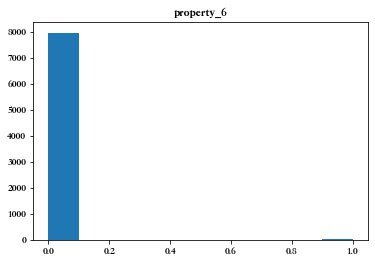

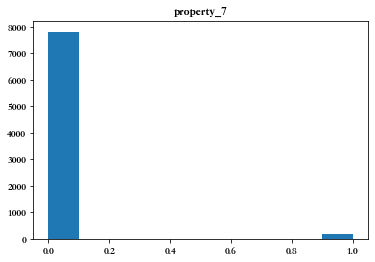

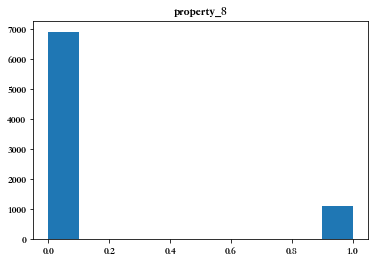

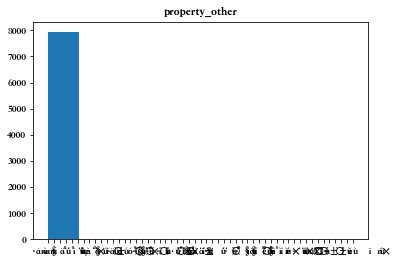

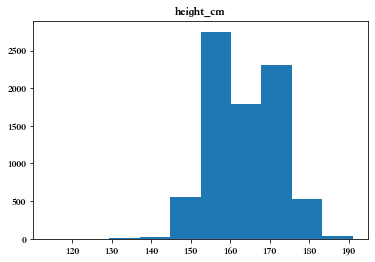

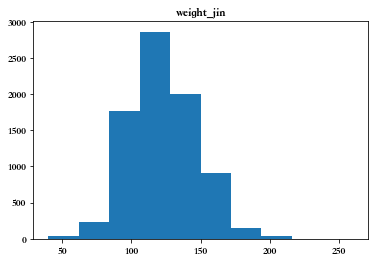

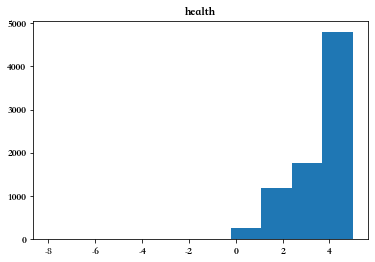

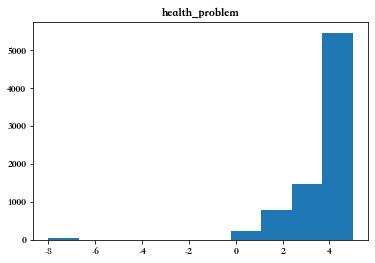

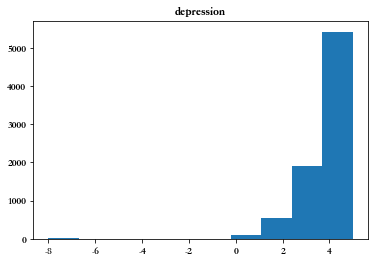

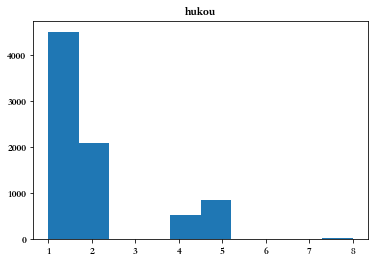

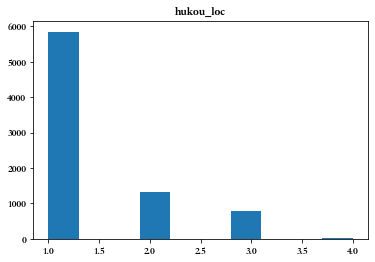

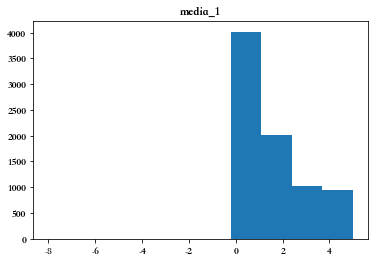

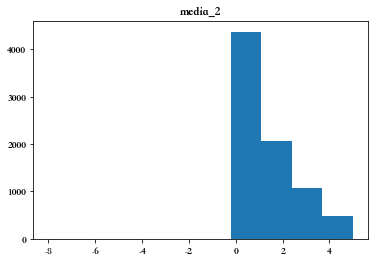

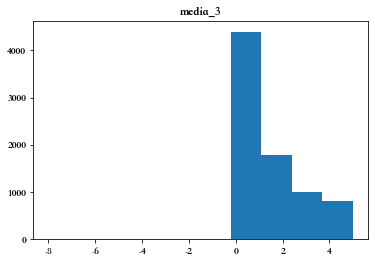

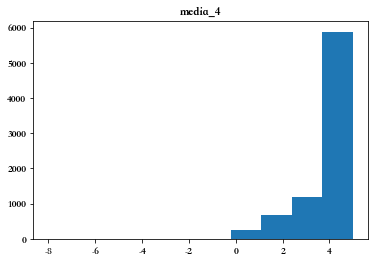

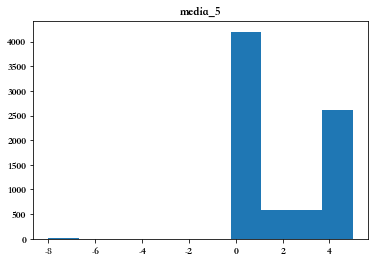

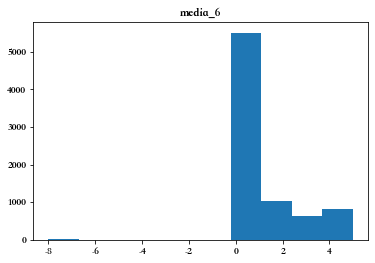

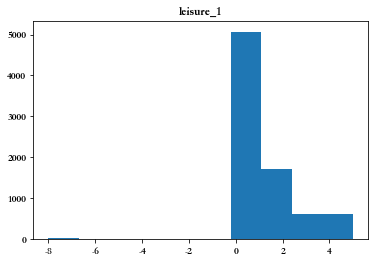

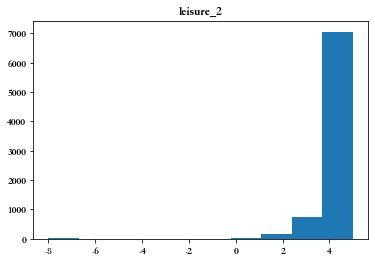

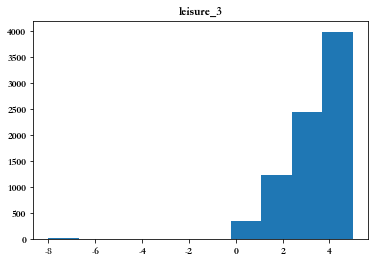

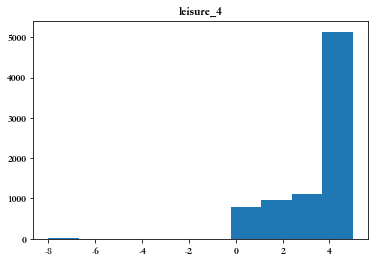

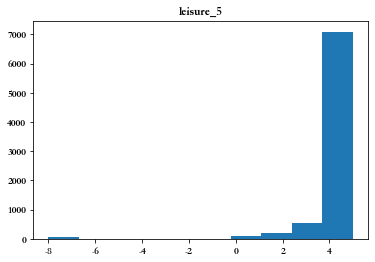

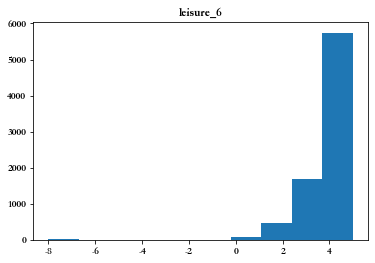

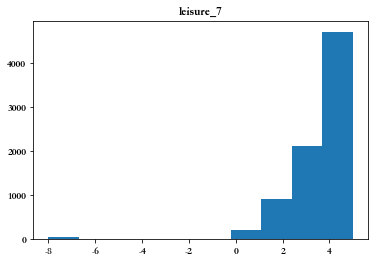

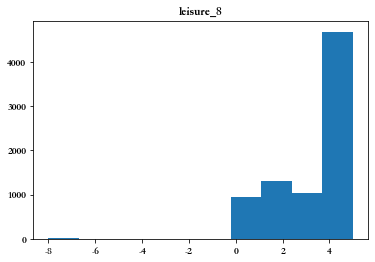

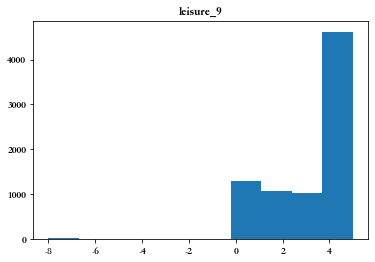

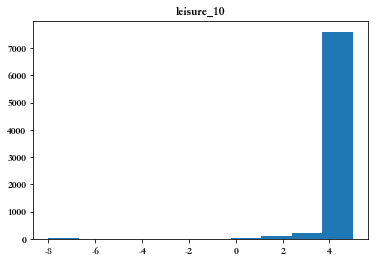

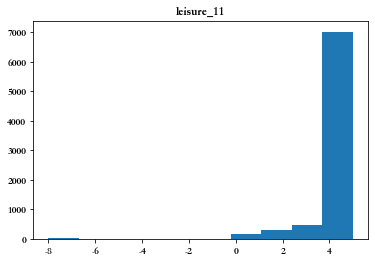

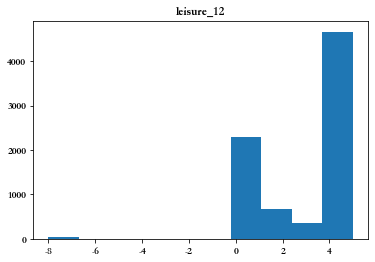

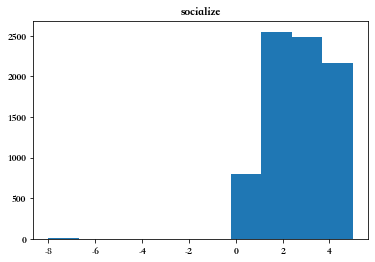

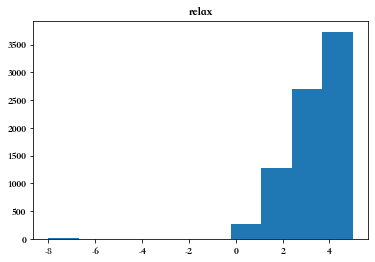

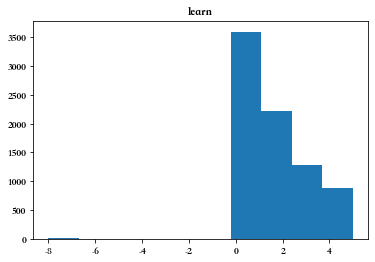

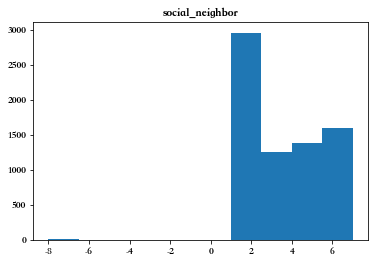

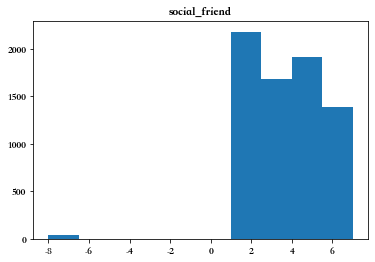

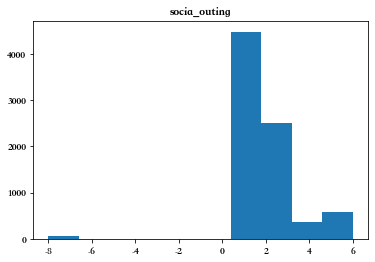

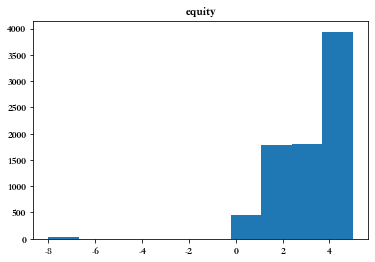

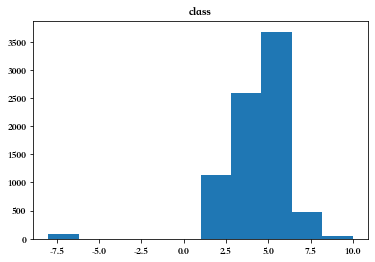

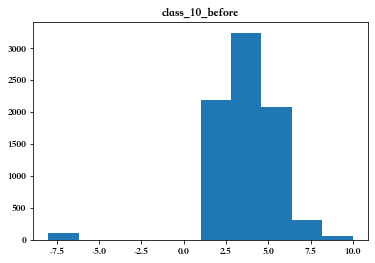

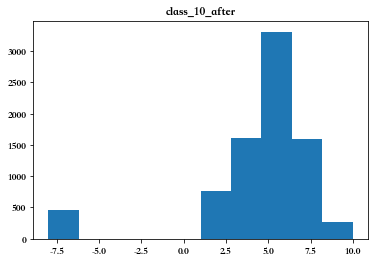

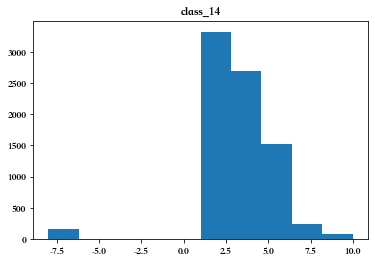

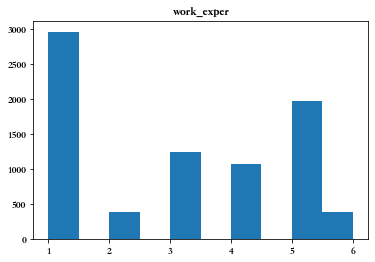

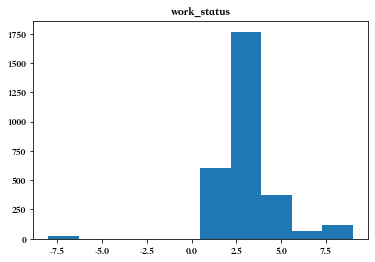

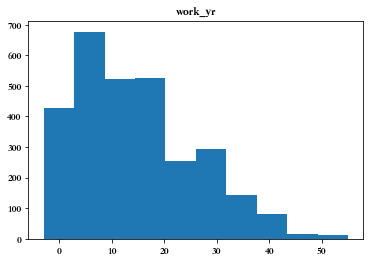

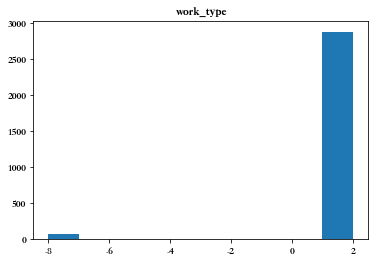

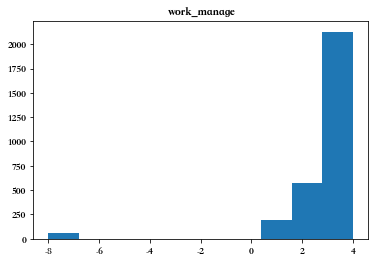

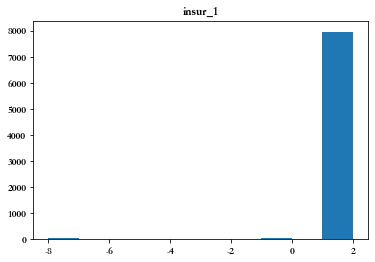

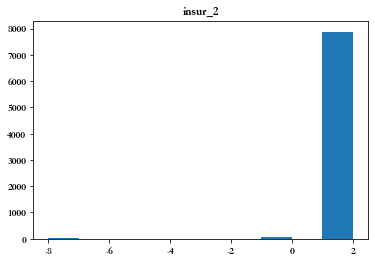

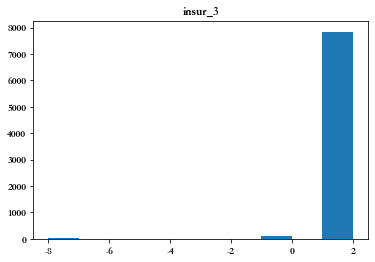

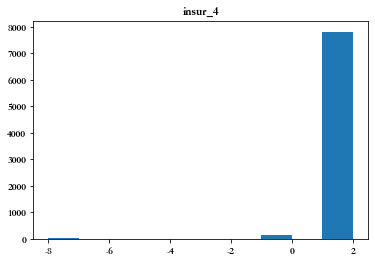

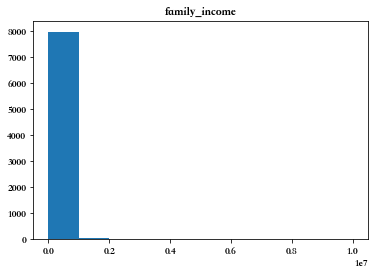

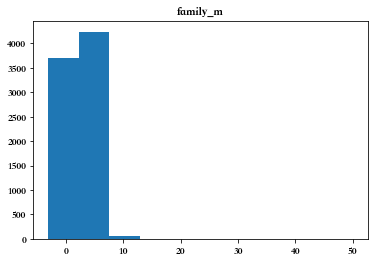

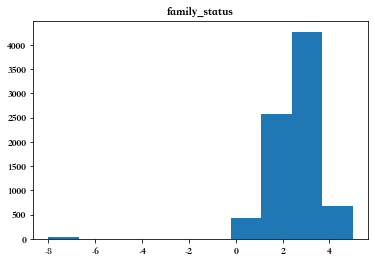

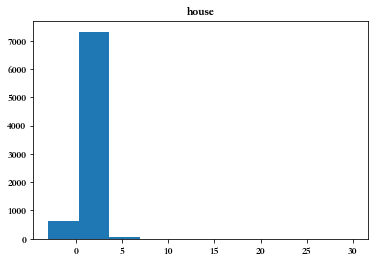

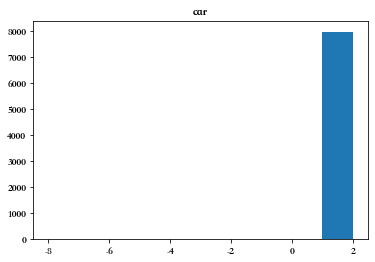

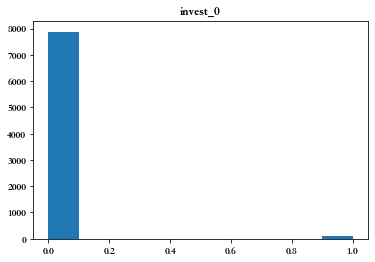

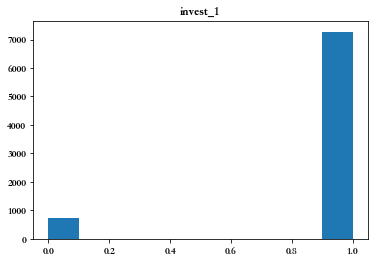

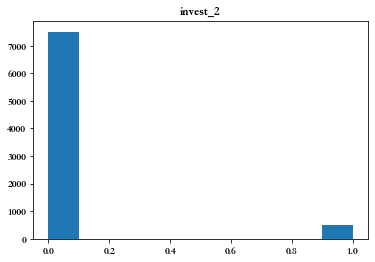

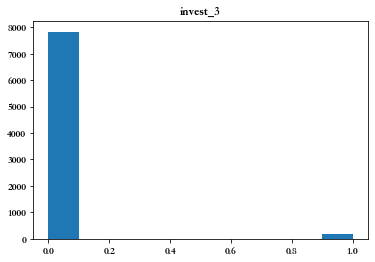

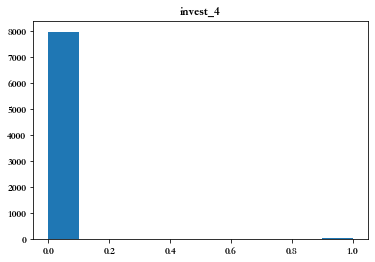

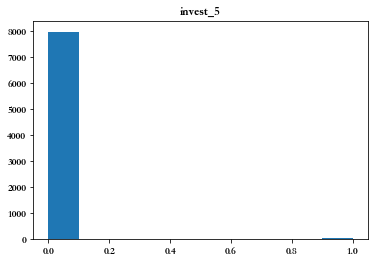

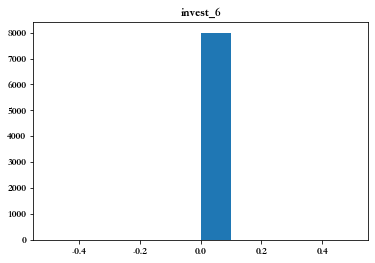

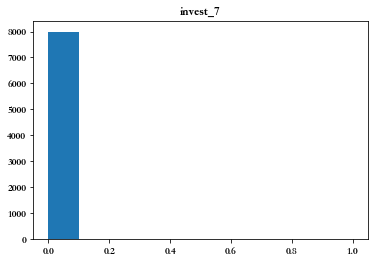

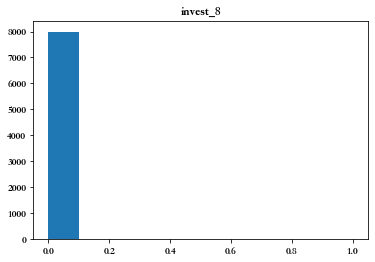

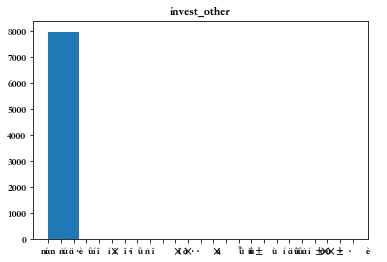

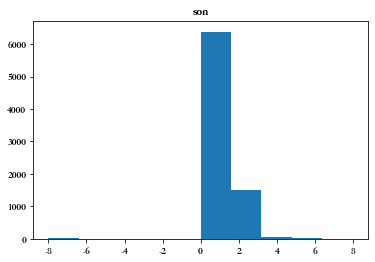

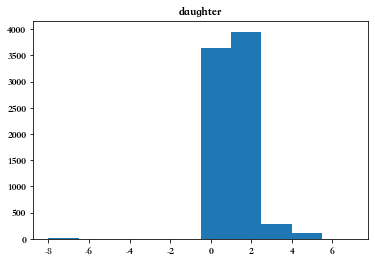

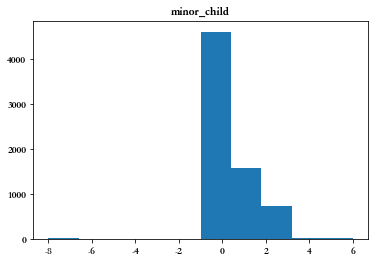

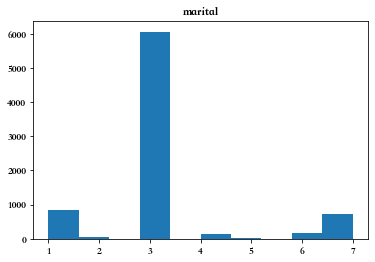

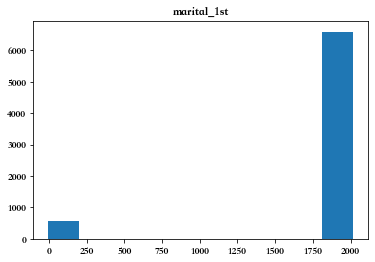

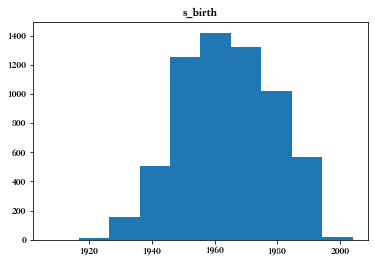

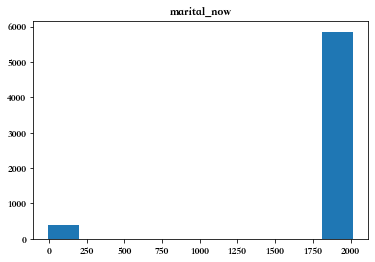

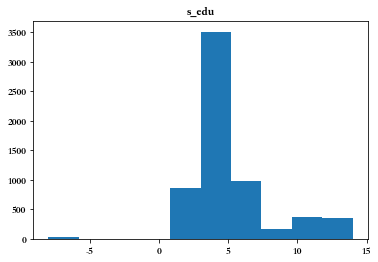

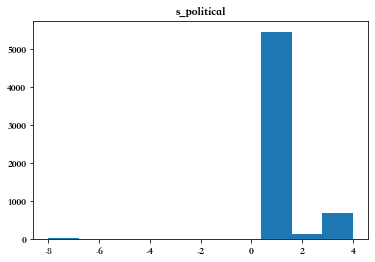

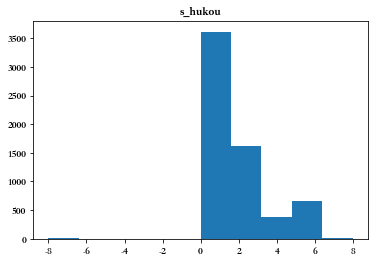

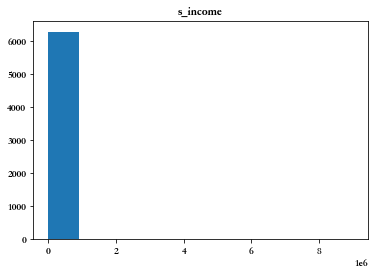

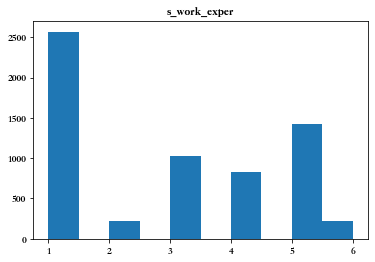

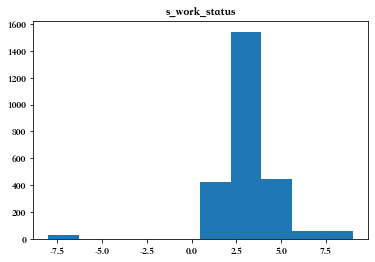

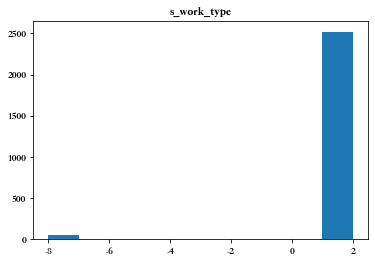

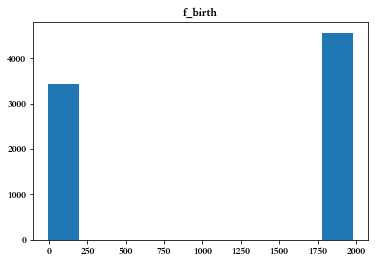

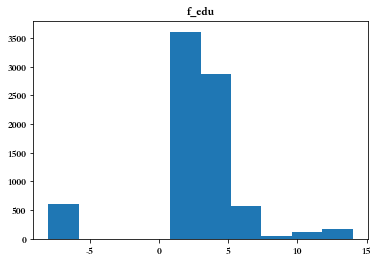

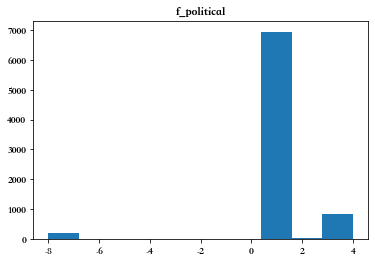

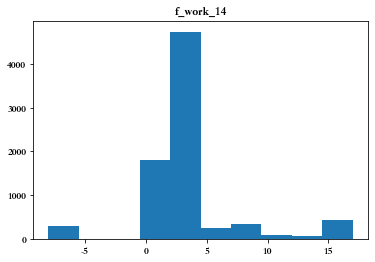

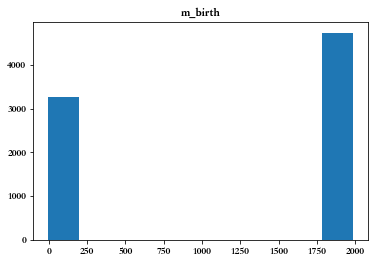

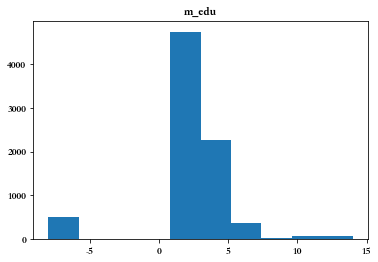

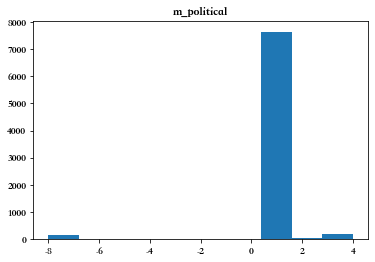

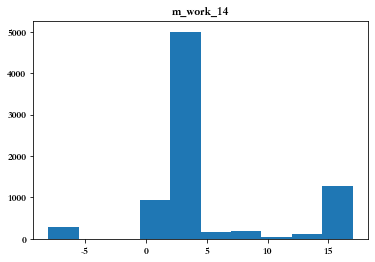

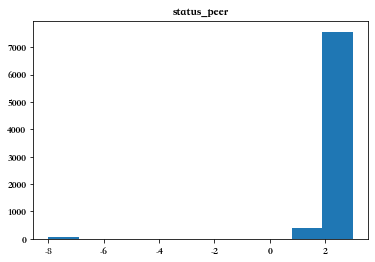

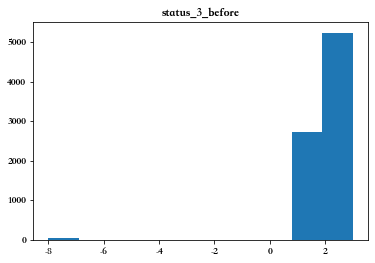

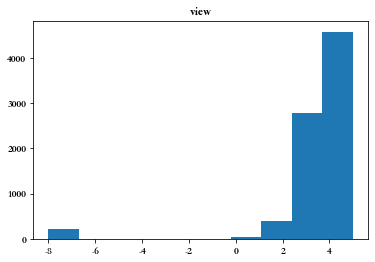

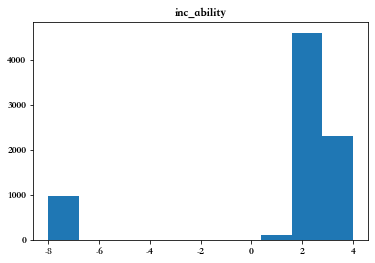

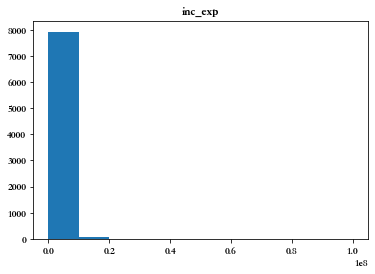

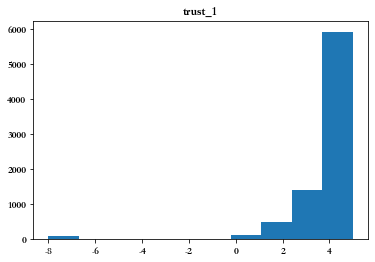

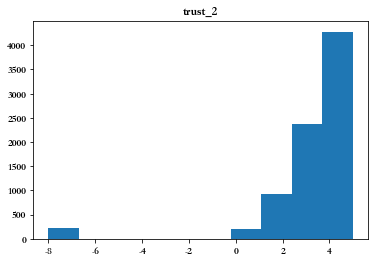

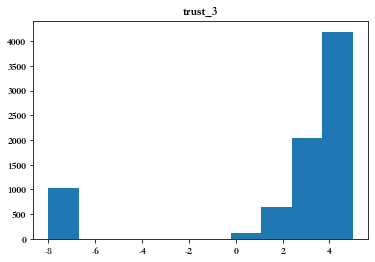

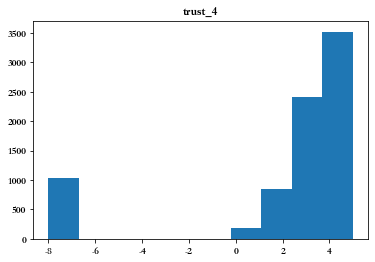

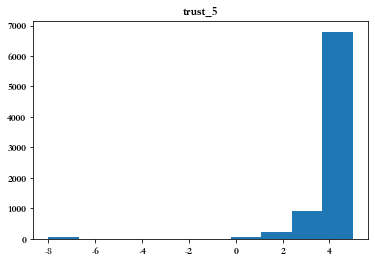

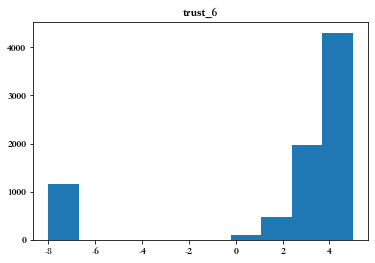

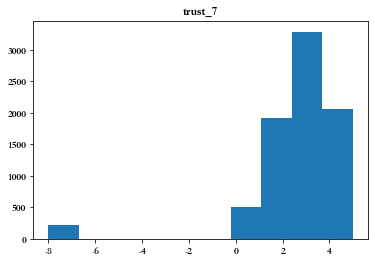

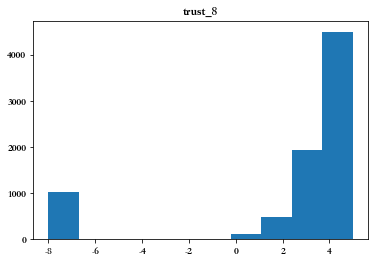

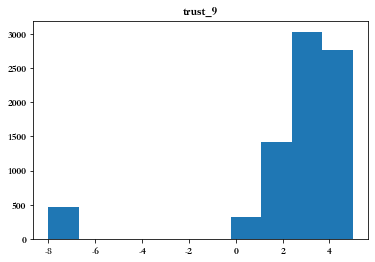

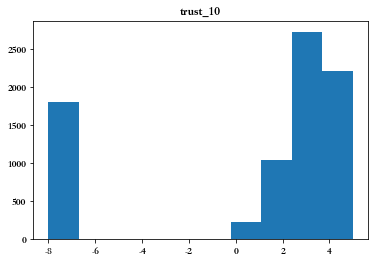

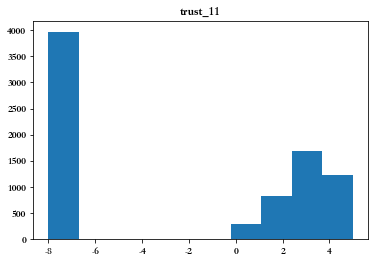

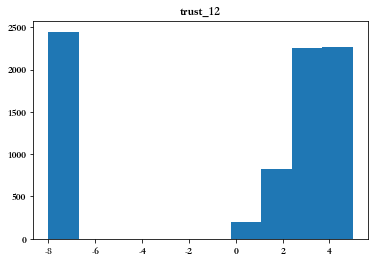

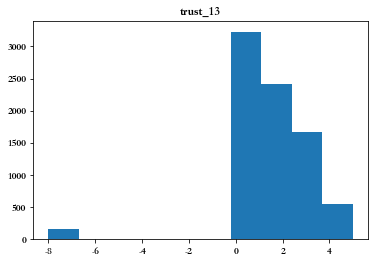

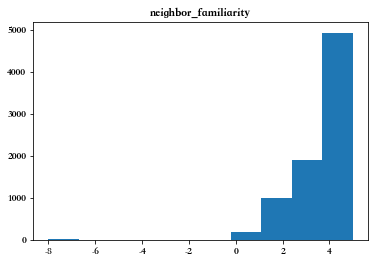

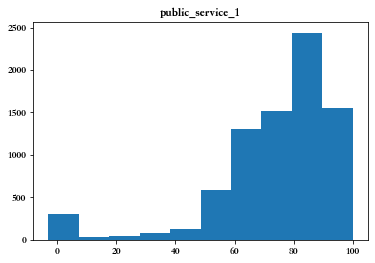

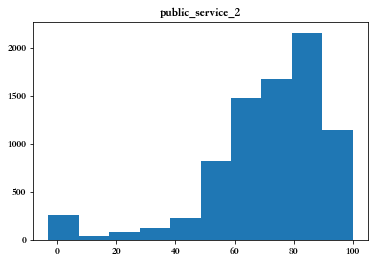

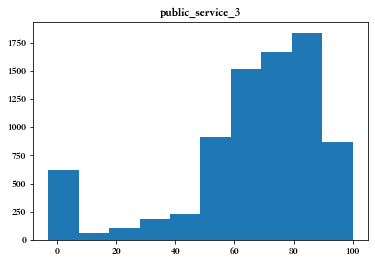

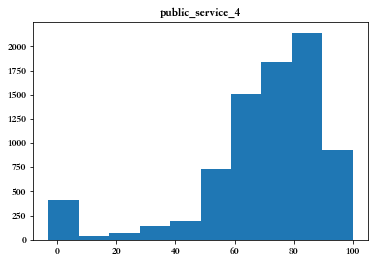

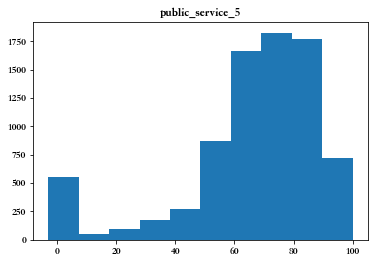

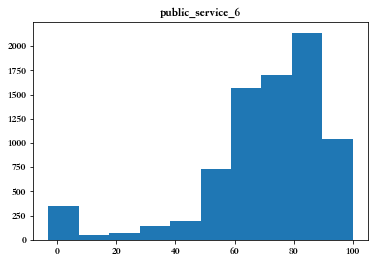

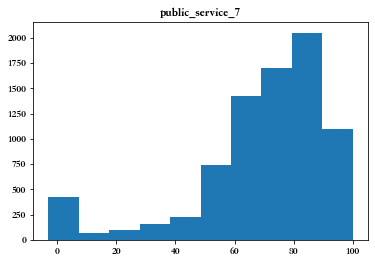

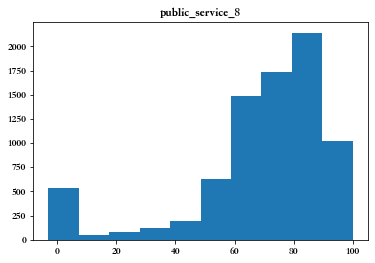

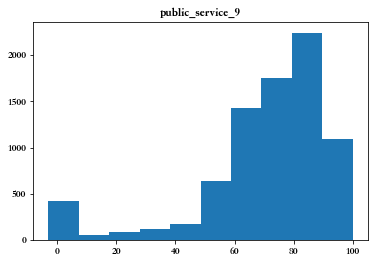

In [68]:
# 无用特征（分布图）
all_columns = df.columns.tolist()

for column in all_columns:
    plt.figure()
    plt.hist(df[column])
    plt.title(column)
    

In [58]:
# 样本是否均衡
df.index.value_counts()


 4    4818
 5    1410
 3    1159
 2     497
 1     104
-8      12
Name: happiness, dtype: int64

In [90]:
# 相关性
corr_df = df.reset_index().corr()["happiness"][1:].abs().sort_values(ascending=False)

check_list= ['nationality', 'religion', 'religion_freq', 'edu_status', 'edu_yr', 'income', 'political', 'join_party', 'property_0', 'property_3', 'property_4', 'property_5', 'property_6', 'property_7', 'property_8', 'property_other', 'leisure_2', 'leisure_10', 'leisure_11', 'work_type', 'insur_1', 'insur_2', 'insur_3', 'insur_4', 'family_income', 'house', 'car', 'invest_1', 'invest_2', 'invest_3', 'invest_4', 'invest_5', 'invest_6', 'invest_7', 'invest_8', 'invest_other', 's_income', 's_work_type', 'm_political', 'status_peer', 'inc_exp']
corr_df[corr_df.index.isin(check_list)].sort_values(ascending=False)




house            0.103013
political        0.094677
status_peer      0.084743
property_0       0.080732
edu_yr           0.067897
religion         0.063539
family_income    0.047654
invest_2         0.045332
property_8       0.042342
insur_3          0.040919
edu_status       0.040527
invest_3         0.038210
insur_4          0.037924
leisure_10       0.033427
property_3       0.031487
invest_4         0.026539
invest_1         0.026244
leisure_2        0.025863
income           0.024056
nationality      0.018928
leisure_11       0.017835
insur_2          0.017432
property_4       0.016762
s_income         0.016738
property_5       0.014323
car              0.012826
property_7       0.011700
m_political      0.011622
property_6       0.010124
invest_5         0.010004
invest_8         0.009244
invest_7         0.004377
insur_1          0.002966
religion_freq    0.002296
inc_exp          0.002001
invest_6              NaN
Name: happiness, dtype: float64

In [62]:
# 重复值
df[df.duplicated()]


Empty DataFrame
Columns: [id, survey_type, province, city, county, survey_time, gender, birth, nationality, religion, religion_freq, edu, edu_other, edu_status, edu_yr, income, political, join_party, floor_area, property_0, property_1, property_2, property_3, property_4, property_5, property_6, property_7, property_8, property_other, height_cm, weight_jin, health, health_problem, depression, hukou, hukou_loc, media_1, media_2, media_3, media_4, media_5, media_6, leisure_1, leisure_2, leisure_3, leisure_4, leisure_5, leisure_6, leisure_7, leisure_8, leisure_9, leisure_10, leisure_11, leisure_12, socialize, relax, learn, social_neighbor, social_friend, socia_outing, equity, class, class_10_before, class_10_after, class_14, work_exper, work_status, work_yr, work_type, work_manage, insur_1, insur_2, insur_3, insur_4, family_income, family_m, family_status, house, car, invest_0, invest_1, invest_2, invest_3, invest_4, invest_5, invest_6, invest_7, invest_8, invest_other, son, daughter, minor_child, marital, marital_1st, s_birth, marital_now, s_edu, s_political, s_hukou, s_income, ...]
Index: []

[0 rows x 139 columns]

## 检查结果

In [ ]:
# 检测结果：
# 形状：8000个样本，139个特征
# 数据类型：float64(25), int64(110), object(4) 暂时还看不出来哪些需要什么样的处理
# 缺失值：有25个特征存在缺失值需要处理，其中超过5000缺失的可以删除，小于2000的可以填充，小于1000的可以删除
# 异常值：存在负值需要处理，离群点需要处理
# 样本均衡：样本不均衡，尤其体现在1、2分人群特别少
# 重复值：没有重复值

# 相关性分析：
## 哪些特征本身缺失太多、异常太大、相关性又低，没价值的就可以删除
## 特征的类别太集中，没有区分度
# nationality
# religion
# religion_freq
# edu_status
# edu_yr
# income
# political
# join_party
# property_0
# property_3
# property_4
# property_5
# property_6
# property_7
# property_8
# property_other
# leisure_2
# leisure_10
# leisure_11
# work_type
# insur_1
# insur_2
# insur_3
# insur_4
# family_income
# house
# car
# invest_1
# invest_2
# invest_3
# invest_4
# invest_5
# invest_6
# invest_7
# invest_8
# invest_other
# s_income
# s_work_type
# m_political
# status_peer
# inc_exp


# 处理思路：
# 内容太多，得先做减法，看看能不能删除一些无用的特征
# 错误值：直接转缺失值
# 题群点：不处理
# 删除特征、均值填充、删除样本
# 批量给特征类型进行分类，之后进行数据类型的转化
# SMOTE均衡

# 数据清洗

## 无用特征处理（个人信息、单分类特征、大量缺失特征）

In [575]:
# 删除信息特征
useless_feature = ["id"]
useless_feature = ["id", "survey_type", "province", "city", "county", "nationality"]
df = df.drop(useless_feature,axis=1)

# city 可以处理成一线城市、二线城市、是否少数民族
# 管理这块，是否管别人，是否被别人管
# 特征既然可以聚合，也可以聚合，需要研究
# 对媒体的使用情况，空闲时间做了什么事情，单个纬度价值不太高，聚合起来或许有意义，你在空闲的时间你能做的事情有多少
# 能做事情多的人，可能就会活得开心点。能做事情少的人，可能活得很孤僻
# 特征是否合适，过分太细了，问的太粗
# 如何对特征做一些归类，做一些分类


In [576]:
# 删除单分类特征
# 找到单分类特征
columns_list = df.columns.tolist()

# 定义单分类列表
one_class_feature_list = []

# 得到单分类特征列表
for column in columns_list:
    feature_count = df[column].value_counts().shape[0]
    if feature_count == 1:
        one_class_feature_list.append(column)

# 删除单分类特征
df = df.drop(one_class_feature_list,axis=1)

In [577]:
# 删除大量缺失的特征（缺失值超过50%的特征直接删除）
# 删除阈值
miss_threshold = 0.5
# 样本综述
sample_count = df.shape[0]
# 删除临界值
delete_count = miss_threshold * sample_count

# 得到需要删除的特征清单
miss_df = df.isnull().sum()
del_miss_feature = miss_df[miss_df>delete_count].index.tolist()
miss_df[miss_df>delete_count]

# 删除特征
df = df.drop(del_miss_feature,axis=1)


## 特征转化 

In [578]:
# 特征转化 

# 受访时间-时间转化 = 年龄
df["survey_time"] = df["survey_time"].apply(lambda x:x[:4]).astype(int)
df["birth"] = df["birth"].astype(int)
df["age"] = df["survey_time"] - df["birth"]
df = df.drop(["survey_time","birth"],axis=1)

# 体重/身高^2 = BMI
df["weight_jin"] = df["weight_jin"].astype(int)
df["height_cm"] = df["height_cm"].astype(int)
df["bmi"] = df["weight_jin"]/(df["height_cm"]**2)
df = df.drop(["weight_jin","height_cm"],axis=1)

## 异常值处理

### 错误值：直接转缺失值

In [579]:
ds_df = df.describe().T
error_columns_list = ds_df[ds_df["min"]<0].index.tolist()
error_columns_list

for column in error_columns_list:
    df[column][df[column]<0]=np.nan



### 离群点 --分箱处理

In [581]:
# 得到需要分享的特征列表（最小值小于1/4，最大值大于3/4）
ds_df = df.describe().T
outlier_feature_list = ds_df[(ds_df["min"]<ds_df["25%"])&(ds_df["max"]>ds_df["75%"])&(ds_df["std"]>ds_df["75%"])].index.tolist()


# 分箱处理
for feature in outlier_feature_list:
    pre_qcut_df = df[feature]

    # 获得带区间的分箱DF
    area_qcut_df = pd.qcut(pre_qcut_df,q=5,duplicates="drop")

    # 定义各区间对应的标签
    rename_df = area_qcut_df.drop_duplicates().sort_values().reset_index(drop=True)
    label_list = rename_df.index.tolist()
    area_list = rename_df.tolist()

    # 将区域转化为标签
    for area,label in zip(area_list,label_list):
        area_qcut_df = area_qcut_df.apply(lambda x:label if x == area else x)

    # 重新定义原始DF
    df[feature] = area_qcut_df.astype(float)

print("对{}个极致差异过大的特征进行 -- 分箱处理，涉及特征有：\n{}\n\n".format(len(outlier_feature_list), outlier_feature_list))



对6个极致差异过大的特征进行 -- 分箱处理，涉及特征有：
['income', 'family_income', 's_income', 'f_work_14', 'm_work_14', 'inc_exp']




## 缺失值处理

### 删除特征处理

In [582]:
#### 特征列表 -- 删除特征
# 父母资料（高度缺失）（父母的资料从客观角度看，跟幸福只是没有什么关系）（缺失原因：可能与不知道父母生日有关）（处理方案：删除特征）
perents_data = ["f_birth", "m_birth"]

delect_feature = perents_data

In [583]:
df = df.drop(delect_feature,axis=1)
print("对{}个特征进行 -- 删除特征处理，涉及特征有：\n{}\n\n".format(len(delect_feature), "、".join(delect_feature)))


对2个特征进行 -- 删除特征处理，涉及特征有：
f_birth、m_birth




### 删除样本处理

In [584]:
# 家庭情况（少量缺失）（跟幸福指数也应该是高度相关）（缺失原因：未知，可能是填写的人不知道平均水平是什么）（处理方案：删除样本处理）
family_list = ["family_status"]

# 健康状况（极少缺失）（健康会影响一个人的幸福指数）（缺失原因：健康没填可能就是身体不好，身体好没理由不填）（处理方案：删除样本处理）
health_list = ["health_problem", "health"]

delect_sample_feature = family_list + health_list


In [585]:
for feature in delect_sample_feature:
    df = df[df[feature].notnull()]

print("对{}个特征进行 -- 删除样本处理，涉及特征有：\n{}\n\n".format(len(delect_feature),"、".join(delect_sample_feature)))


对2个特征进行 -- 删除样本处理，涉及特征有：
family_status、health_problem、health




### 0填充处理

In [586]:
#### 特征列表 -- 0填充处理
# 休闲娱乐情况（少量缺失）（娱乐放松身心，与幸福指数有点关系）（缺失原因：应该和没有参与这类娱乐有关）（处理方案：考虑0填充造0特征）
leisure_list = ["leisure_1","leisure_2","leisure_3","leisure_4","leisure_5","leisure_6","leisure_7","leisure_8","leisure_9","leisure_10","leisure_11","leisure_12"]

# 使用媒体的情况（少量缺失）（也是一种休闲方式，与幸福指数有点关系）（缺失原因：不填写可能与不实用有关系）（处理方案：考虑0填充造0特征）
media_list = ["media_1","media_2","media_3","media_4","media_5","media_6"]

# 单身特征（大量缺失）（并且一个人的幸福指数可能会与配偶的背景富裕程度相关）（缺失原因：可能是单身导致的缺失值）（处理方案：造0特征、删除样本处理）
single_feature = ['marital_now', 'marital_1st', 's_hukou', 's_work_exper', 's_birth', 's_edu', 's_political',
                  's_income']

# 教育背景（大量缺失）（教育程度或许会与幸福指数有关）（缺失原因：未知，可能是没读过书所以没填写）（处理方案：首先考虑造0特征，其次填充、删除样本）
edu_list = ['edu_yr','edu_status']

# 子女状况（没有缺失）（或许跟幸福指数有关）（缺失原因：没填可能就是没有）（处理方案：0填充）
kid_list = ["daughter", "son", 'minor_child']

# 信任度 （高度缺失）(人与人的信任度，也会构成幸福感，防备心太重会让人很痛苦)(缺失原因：可能是因为没涉及到这类人群)（处理方案：考虑0填充造0特征）
trust_list = ["trust_1", "trust_2", "trust_3", "trust_4", "trust_5", "trust_6", "trust_7", "trust_8", "trust_9",
              "trust_10", "trust_11", "trust_12", "trust_13"]

zero_feature = leisure_list + media_list + single_feature + edu_list + kid_list + trust_list



In [587]:
for feature in zero_feature:
    df[feature] = df[feature].fillna(0)

print("对{}个特征进行 -- 0填充处理，涉及特征有：\n{}\n\n".format(len(zero_feature), "、".join(zero_feature)))


对44个特征进行 -- 0填充处理，涉及特征有：
leisure_1、leisure_2、leisure_3、leisure_4、leisure_5、leisure_6、leisure_7、leisure_8、leisure_9、leisure_10、leisure_11、leisure_12、media_1、media_2、media_3、media_4、media_5、media_6、marital_now、marital_1st、s_hukou、s_work_exper、s_birth、s_edu、s_political、s_income、edu_yr、edu_status、daughter、son、minor_child、trust_1、trust_2、trust_3、trust_4、trust_5、trust_6、trust_7、trust_8、trust_9、trust_10、trust_11、trust_12、trust_13




### 众数填充

In [588]:
#### 特征列表 -- 众数填充
# 内在感知情况（中小量缺失）（这部分与幸福感是直接相关，且应该跟多数人达成共识）（缺失原因：未知原因）（处理方案：首先填充，其次众数）
inner_list = ["view", "equity", "inc_ability","learn", "depression", "edu", "relax"]

mode_feature = inner_list

In [589]:
###### 处理 -- 众数填充
for feature in mode_feature:
    mode_value = df[feature].max()
    df[feature] = df[feature].fillna(mode_value)

print("对{}个特征进行 -- 众数填充处理，涉及特征有：\n{}\n\n".format(len(mode_feature), "、".join(mode_feature)))


对7个特征进行 -- 众数填充处理，涉及特征有：
view、equity、inc_ability、learn、depression、edu、relax




### 特定填充

In [590]:
#### 特征列表 -- 特定填充
# 社交状况，社交没填可能就是没社交，选用无社交的选项（对应7，7，1，1，1）
relationship_list = ['social_friend', 'social_neighbor', "neighbor_familiarity", "socialize", "socia_outing"]
relationship_num = [7, 7, 1, 1, 1]

# 户口状况，没填可能没有户口，选用无户口的选项（对应4）
hukou_list = ["hukou_loc"]
hukou_num = [4]

# 信仰情况，没填可能无信仰，选用无信仰选项（对应0，1）
religion_list = ["religion", "religion_freq"]
religion_num = [0, 1]

feature_list = relationship_list + hukou_list + religion_list
stuff_value = relationship_num + hukou_num + religion_num

In [591]:
for feature, stuff in zip(feature_list, stuff_value):
    df[feature][df[feature].isnull()] = stuff

print("对{}个特征进行 -- 特定填充处理，涉及特征有：\n{}\n\n".format(len(feature_list), "、".join(feature_list)))


对8个特征进行 -- 特定填充处理，涉及特征有：
social_friend、social_neighbor、neighbor_familiarity、socialize、socia_outing、hukou_loc、religion、religion_freq




### 模型填充

In [592]:
# 多次对比实验证明，删除样本效果最好，不知道总比乱说强

def model_stuff_value(df,feature,model="clf",stuff_index = 0.8):
    global RF
    # 判断是否存在缺失值，如果没有缺失值，直接结束
    miss_counts = df[feature].isnull().sum()

    if miss_counts == 0:
        print("特征{} 无缺失值\n".format(feature))
        return (df)

    # 提示开始填充
    print("正在尝试填充特征{}...".format(feature))

    # 还原DF
    pre_stuff_df = df.reset_index()

    # 给需要预测的标签设置索引（缺失值-9填充）
    pre_stuff_df[feature] = pre_stuff_df[feature].fillna(-9)
    pre_stuff_df = pre_stuff_df.set_index(feature)

    # 删除有缺失值的列(改为获得删除的列名)
    drop_df = pre_stuff_df.isnull().sum()
    drop_list = drop_df[drop_df>0].index.tolist()

    # 设置训练集、测试集（标签不为null）
    train_data =  pre_stuff_df[pre_stuff_df.index != -9]
    stuff_data = pre_stuff_df[pre_stuff_df.index == -9]

    # 设置x，y，排序，且使得样本均衡 （此处才删除缺失列）
    train_x = train_data.drop(drop_list,axis=1)
    train_y = train_data.drop(drop_list,axis=1).index
    stuff_x = stuff_data.drop(drop_list,axis=1)

    # 使用随机森林填充
    if model == "clf":
        RF = RandomForestClassifier()

    elif model == "re":
        RF = RandomForestRegressor()

    print("开始交叉验证准确度....")
    score_all = cross_val_score(RF,train_x,train_y.astype(int),cv=2,n_jobs=-1)
    model_score = np.mean(score_all)
    print("模型拟合准确度：{}".format(model_score))

    if model_score < stuff_index:
#         print("准确度太低,改为0填充处理")
#         df[feature] = df[feature].fillna(0)
#         print("准确度太低,放弃填充，删特征处理")
#         df = df.drop(feature,axis=1)
        
        print("准确度太低,放弃填充，删样本处理")
        df = df[df[feature].notnull()]
        print("一共删除{}条样本\n".format(miss_counts))

        return (df)

    # 训练
    RF.fit(train_x,train_y)

    # 预测
    stuff_values = RF.predict(stuff_x)

    # 获得填充后的DF
    stuff_df = stuff_x.set_index(stuff_values)

    # 合并，填充完毕
    df = train_data.append(stuff_df)

    # 将标签设为索引()
    df = df.reset_index().set_index("happiness")
    df = df.rename(columns={"index":feature}) # 之前的标签还原回来之后名字缺失了，需要将index这个名字人工改为原始的名字

    print("填充完毕！\n")

    return (df)


In [593]:
#### 特征列表 -- 模型填充
# 社会满意度(少量缺失)(社会满意度高与幸福指数也应该有关系)(缺失原因：不太能确定，可能是对服务不满不想填,或者不知道怎么填)(考虑填充，填充不了就删除样本)
public_list = ["public_service_1", "public_service_2", "public_service_3", "public_service_4",
               "public_service_5", "public_service_6", "public_service_7", "public_service_8",
               "public_service_9"]

# 社保情况（少量缺失）（有社会保障应该也与幸福指数有关系）（缺失原因：不明原因）(处理方案：填充，删除样本)
insur_list = ["insur_1", "insur_2", "insur_3", "insur_4"]

# 财富情况（极少量缺失）（跟幸福指数也应该是高度相关）（缺失原因：没填写可能是因为没车、没房）（处理方案：填充、删除样本、考虑0填充）
wealth_list = ["house", "family_m", "car"]


# 个人地位情况（少量缺失）（地位会影响一个人的幸福指数）（缺失原因：未知）（处理方案：填充、删除样本）
position_list = ["political", "class", "class_14", "class_10_before", "class_10_after", "status_3_before",
                 "status_peer"]

# 收入情况（中量缺失）（收入与幸福有关）（缺失原因：可能是没收入，或者不方便透露）（处理方案：首先考虑模型填充，其次考虑删除样本，或者0填充,删除特征是不可取的）
income_list = ['income', 'family_income','inc_exp'] # 可以中位数处理

# 父母资料（少量缺失）（父母的工作、政治地位与幸福指数会有关系）（缺失原因：可能是不方便透露）（处理方案：填充、删除特征）
perents_list = ["f_edu", "f_political", "f_work_14", "m_edu", "m_political", "m_work_14"]

model_stuff_feature = public_list + insur_list + wealth_list + position_list + income_list + perents_list



In [594]:
#### 处理 -- 模型预测填充模型
# 此处应该是自动区分 类别型数据、数值型数据
des_df = df[model_stuff_feature].describe().T
# 回归填充（连续性数值）（最大值大于20判别）
re_list = des_df[des_df["max"] >= 20].index.tolist()

# 分类填充（类别型数据）（最大值小于20判别）
clf_list = des_df[des_df["max"] < 20].index.tolist()

for i in re_list:
    df = model_stuff_value(df, feature=i, model="re") # 增加指定阈值，小于多少就不填充(需要提示现在正在填充哪个缺失值，模型情况如何，是否填充)

for i in clf_list:
    try:
        df = model_stuff_value(df, feature=i, model="clf")
    except Exception:
        print(i)




正在尝试填充特征public_service_1...
开始交叉验证准确度....
模型拟合准确度：0.05180442004860819
准确度太低,放弃填充，删样本处理
一共删除219条样本

正在尝试填充特征public_service_2...
开始交叉验证准确度....
模型拟合准确度：0.45497459556178144
准确度太低,放弃填充，删样本处理
一共删除29条样本

正在尝试填充特征public_service_3...
开始交叉验证准确度....
模型拟合准确度：0.4612405168159353
准确度太低,放弃填充，删样本处理
一共删除247条样本

正在尝试填充特征public_service_4...
开始交叉验证准确度....
模型拟合准确度：0.5777852156521704
准确度太低,放弃填充，删样本处理
一共删除64条样本

正在尝试填充特征public_service_5...
开始交叉验证准确度....
模型拟合准确度：0.5873927069733279
准确度太低,放弃填充，删样本处理
一共删除67条样本

正在尝试填充特征public_service_6...
开始交叉验证准确度....
模型拟合准确度：0.6568198646016717
准确度太低,放弃填充，删样本处理
一共删除10条样本

正在尝试填充特征public_service_7...
开始交叉验证准确度....
模型拟合准确度：0.5796728281762029
准确度太低,放弃填充，删样本处理
一共删除53条样本

正在尝试填充特征public_service_8...
开始交叉验证准确度....
模型拟合准确度：0.5727092380743604
准确度太低,放弃填充，删样本处理
一共删除106条样本

正在尝试填充特征public_service_9...
开始交叉验证准确度....
模型拟合准确度：0.5959279169213412
准确度太低,放弃填充，删样本处理
一共删除14条样本

正在尝试填充特征house...
开始交叉验证准确度....
模型拟合准确度：0.0016338548432935363
准确度太低,放弃填充，删样本处理
一共删除97条样本

正在尝试填充特征family_m...
开始交叉验证准确度....

### 暴力填充

In [595]:
# 缺失值处理
miss_df = df.isnull().sum()
miss_feature = miss_df.index.tolist()

#均值填充(不能均值就众数)
for i in miss_feature:
    try:
        df[i] = df[i].fillna(df[i].mean())
    except Exception:
        df[i] = df[i].fillna(df[i].mode()[0])


In [596]:
# 检查一下缺失处理的干不干净,剩下多少样本
print(df.shape)
df.isnull().sum().sort_values(ascending=False)


(4835, 118)


bmi                     0
leisure_8               0
media_2                 0
media_3                 0
media_4                 0
media_5                 0
media_6                 0
leisure_1               0
leisure_2               0
leisure_3               0
leisure_4               0
leisure_5               0
leisure_6               0
leisure_7               0
leisure_9               0
hukou_loc               0
leisure_10              0
leisure_11              0
leisure_12              0
socialize               0
relax                   0
learn                   0
social_neighbor         0
social_friend           0
socia_outing            0
equity                  0
class                   0
class_10_before         0
media_1                 0
hukou                   0
age                     0
edu_yr                  0
f_work_14               0
f_political             0
political               0
car                     0
insur_4                 0
insur_3                 0
insur_1     

# 特征工程

In [597]:
# 得到需要处理的各类数据
onehot_df = df.select_dtypes("object")
std_df = df.select_dtypes("number")

# 进行标准化
ss = StandardScaler()
std_array = ss.fit_transform(std_df)
std_df = pd.DataFrame(std_array,index=std_df.index,columns=std_df.columns)

fe_df = pd.concat([std_df,onehot_df],axis=1)
fe_df

m_political  f_work_14  f_political  political       car   insur_4  \
happiness                                                                       
4            -0.162037  -0.467438     2.767007  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794 -3.814004   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
5            -0.162037  -0.467438    -0.364659  -0.397433 -2.146870  0.262192   
5            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433 -2.146870  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438     2.767007   2.799883  0.465794  0.262192   
2            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794 -3.814004   
4            -0.162037  -0.467438    -0.364659  -0.397433 -2.146870  0.262192   
5            -0.162037  -0.467438    -0.364659   2.799883 -2.146870  0.262192   
4            -0.162037  -0.467438     2.767007  -0.397433  0.465794  0.262192   
5            -0.162037  -0.467438    -0.364659  -0.397433 -2.146870  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
3            -0.162037   2.139323    -0.364659   0.668339  0.465794  0.262192   
5            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794 -3.814004   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037   2.139323    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
5            -0.162037   2.139323    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438     2.767007   0.668339  0.465794  0.262192   
4            -0.162037   2.139323    -0.364659   0.668339  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
5            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
5            -0.162037   2.139323     2.767007  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037   2.139323    -0.364659   2.799883  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659   2.799883  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037   2.139323    -0.364659  -0.397433  0.465794  0.262192   
3            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037   2.139323    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037   2.139323     2.767007  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659   0.668339  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.364659   0.668339  0.465794  0.262192   
1            -0.162037  -0.467438    -0.364659  -0.397433  0.465794  0.262192   
4            -0.162037  -0.467438    -0.36

# 数据切割与SMOTE均衡

In [598]:
# 定义特征工程
tem_df = fe_df

# 切分数据
x = tem_df.values
y = tem_df.index.values
columns_list = tem_df.columns
index_list = tem_df.index

# 得到测试集
raw_x,test_x,raw_y,test_y = train_test_split(x,y,test_size=0.1,random_state=34)

# 得到训练集与验证集
train_x,vail_x,train_y,vail_y = train_test_split(raw_x,raw_y,test_size=0.3,random_state=34)

# 对训练集进行SMOTE上采样 
smo = SMOTE(random_state=34,k_neighbors=4)
smo_train_x , smo_train_y = smo.fit_sample(train_x,train_y)
print(smo_train_x.shape)
print(smo_train_y.shape)


(9300, 118)
(9300,)


# 模型选择

In [567]:
# 分类模型测试
model_list = [KNeighborsClassifier,BernoulliNB,GaussianNB,LogisticRegression,SVC,RandomForestClassifier,GradientBoostingClassifier,XGBClassifier,LGBMClassifier,CatBoostClassifier]
name_list = ["KNeighborsClassifier","BernoulliNB","GaussianNB","LogisticRegression","SVC","RandomForestClassifier","GradientBoostingClassifier","XGBClassifier","LGBMClassifier","CatBoostClassifier"]

# 默认参数
best_model = "" # 默认最优模型
best_score = -np.inf # 默认最优准确率

for MODEL,name in zip(model_list,name_list):
    # 建立模型
    model = MODEL()

    #socre_list = cross_val_score(model,raw_x ,raw_y,cv=5,n_jobs=-1,scoring="accuracy")    
    socre_list = cross_val_score(model,smo_train_x,smo_train_y,cv=2,n_jobs=-1,scoring="accuracy")
    
    score = socre_list.mean()
    
    # 输出模型名称与准确率与方差
    print("\n当前模型:{}，准确率:{}".format(name,score))
    
    # 判断是否最优更新结果
    if score > best_score:
        best_score,best_model = score,name
        
    
# 输出最优结果
print("\n\n最优模型:{}，准确率:{}".format(best_model,best_score))



当前模型:KNeighborsClassifier，准确率:0.7674193548387096

当前模型:BernoulliNB，准确率:0.4972043010752688

当前模型:GaussianNB，准确率:0.27666666666666667

当前模型:LogisticRegression，准确率:0.6683870967741936

当前模型:SVC，准确率:0.8550537634408601

当前模型:RandomForestClassifier，准确率:0.8819354838709677

当前模型:GradientBoostingClassifier，准确率:0.7979569892473118

当前模型:XGBClassifier，准确率:0.841720430107527

当前模型:LGBMClassifier，准确率:0.8388172043010753

当前模型:CatBoostClassifier，准确率:0.8262365591397849


最优模型:RandomForestClassifier，准确率:0.8819354838709677


In [55]:
# 回归测试
# 回归模型测试
model_list = [KNeighborsRegressor,
              LinearRegression,SVR,RandomForestRegressor,
              GradientBoostingRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor]
name_list = ["KNeighborsRegressor",
              "LinearRegression","SVR","RandomForestRegressor",
              "GradientBoostingRegressor","XGBRegressor","LGBMRegressor","CatBoostRegressor"]


# 默认参数
best_model = "" # 默认最优模型
best_score = -np.inf # 默认最优准确率

for MODEL,name in zip(model_list,name_list):
    # 建立模型
    model = MODEL()
    
    socre_list = cross_val_score(model,raw_x ,raw_y,cv=5,n_jobs=-1,scoring="r2")
    #socre_list = cross_val_score(model,smo_train_x , smo_train_y,cv=1,n_jobs=-1,scoring="r2")
    
    score = socre_list.mean()
    
    # 输出模型名称与准确率与方差
    print("\n当前模型:{}，准确率:{}".format(name,score))
    
    # 判断是否最优更新结果
    if score > best_score:
        best_score,best_model = score,name
        
    
# 输出最优结果
print("\n\n最优模型:{}，准确率:{}".format(best_model,best_score))


当前模型:KNeighborsRegressor，准确率:0.03611992271805098

当前模型:LinearRegression，准确率:0.21744202266762147

当前模型:SVR，准确率:0.18532531357175305

当前模型:RandomForestRegressor，准确率:0.23613361838859906

当前模型:GradientBoostingRegressor，准确率:0.23681083029420275

当前模型:XGBRegressor，准确率:0.13960121586367485

当前模型:LGBMRegressor，准确率:0.22901767958791236

当前模型:CatBoostRegressor，准确率:0.2531547848766915


最优模型:CatBoostRegressor，准确率:0.2531547848766915


In [475]:
lenth = raw_y.shape[0]
class_count = np.unique(raw_y).shape[0]
class_shape =(lenth,class_count)
class_shape

(4351, 5)

In [477]:
np.unique(raw_y)

array([1, 2, 3, 4, 5])

# 建模

## 自写K折训练函数

In [539]:
# K折训练类
class KFold_Fit():
    def __init__(self, model, n_splits=5, random_state=34, shuffle=True,verbose=True,scoring="r2"):
        # 定义模型
        self.model = model
        
        # 定义n_splits
        self.n_splits = n_splits
        
        # 定义KFOLD
        self.kfold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
        
        # 定义verbose
        self.verbose = verbose
        
        # 建立模型识别列表
        self.classifer_list = ["KNeighborsClassifier","BernoulliNB","GaussianNB",
             "LogisticRegression","SVC","RandomForestClassifier",
             "GradientBoostingClassifier","XGBClassifier","LGBMClassifier",
             "CatBoostClassifier"]

        self.regression_list = ["KNeighborsRegressor",
              "LinearRegression","SVR","RandomForestRegressor",
              "GradientBoostingRegressor","XGBRegressor","LGBMRegressor","CatBoostRegressor"]
        
        # 指定评估指标
        from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score,auc,f1_score,r2_score,mean_squared_error,mean_absolute_error
        score_dict = {"accurcay":accuracy_score,
                      "f1":f1_score,
                      "precision":precision_score,
                      "recall":recall_score,
                      "roc_auc":roc_auc_score,
                      "r2":r2_score,
                      "neg_mean_absolute_error":mean_absolute_error,
                      "neg_mean_squared_error":mean_squared_error    
                        }
        
        # 定义评估指标
        self.scoring = score_dict[scoring]
        

    def fit(self, raw_x, raw_y):
        # 定义初始循环次数
        n=0
        
        # 定义模型缓冲区（）
        self.k_model_cache = []
        
        # 定义feature_importance
        self.feature_importance = np.zeros(raw_x.shape).astype(float) # 生成与特征数同样多的零合矩阵
        
        # 定义oof
        if self.model.__class__.__name__ in self.regression_list: # 回归模型的oof（样本，）
            self.oof = np.zeros(raw_y.shape).astype(float) # 生成与样本数同样多的零合矩阵
        elif self.model.__class__.__name__ in self.classifer_list: # 分类模型的oof （样本，特征数）
            lenth = raw_y.shape[0]
            class_count = np.unique(raw_y).shape[0]
            class_shape =(lenth,class_count)
            self.oof = np.zeros(class_shape).astype(float)
        

        for train_index, vail_index in self.kfold.split(raw_x, raw_y):
            train_x, train_y = raw_x[train_index], raw_y[train_index]
            vail_x, vail_y = raw_x[vail_index], raw_y[vail_index]

            # 模型训练
            now_model = copy.copy(self.model) # 深拷贝，否则传入列表的都为同一个模型
            now_model.fit(train_x, train_y)
            self.k_model_cache.append(now_model)  
            
            # 得到之后需要追加的数据
            # 分类模型
            if now_model.__class__.__name__ in self.classifer_list:
                oof_now = now_model.predict_proba(vail_x)

            # 回归模型
            elif now_model.__class__.__name__ in self.regression_list:
                oof_now = now_model.predict(vail_x)
            
            
            # 评估验证集
            pred_vail_y = now_model.predict(vail_x)
            score = self.scoring(vail_y,pred_vail_y)
            if self.verbose==True:
                print(f"第{n}次验证集score为:", score)

            # 追加数据
            self.oof[vail_index] += oof_now  # 追加oof (指定追加到相应的索引位置)
            self.feature_importance += now_model.feature_importances_  # 追加importance
            
            n +=1



    def predict(self,test_x):
        now_model = self.k_model_cache[0]
        
        # 回归模型
        if now_model.__class__.__name__ in self.regression_list:
            # 定义pred_test_y （样本，）
            pred_test_y = np.zeros(test_x.shape[0])
            
            # 遍历所有KFOLD保存下来的模型
            for model in self.k_model_cache:
                pred_test_y += model.predict(test_x)  # 追加pred_test_y

            # 得到最终输出值
            pred_test_y = pred_test_y / self.n_splits
        

        # 分类模型
        elif now_model.__class__.__name__ in self.classifer_list:
            # 定义prob_test_y（样本，特征数）
            class_shape = now_model.predict_proba(test_x).shape
            prob_test_y = np.zeros(class_shape).astype(float)
            
            # 遍历所有KFOLD保存下来的模型
            for model in self.k_model_cache:
                prob_test_y += model.predict_proba(test_x)  # 追加pred_test_y
            # 得到最终输出值
            prob_test_y = prob_test_y / self.n_splits
            pred_test_y = np.argmax(prob_test_y,axis=1)            
            
            
        return (pred_test_y)

    def feature_importances_(self):
        feature_importance = self.feature_importance / self.n_splits
        return feature_importance

    def get_oof(self):
        return self.oof
    
    

## XGB建模（对比原始、五折的训练结果、调参数）

In [599]:
# 建模预测评估
model_xgb = XGBRegressor(random_state=34)


# 模型训练
model_xgb.fit(train_x,train_y)
#model_xgb.fit(smo_train_x , smo_train_y)

# # 预测
pred_y = model_xgb.predict(test_x)
# 评估
score = r2_score(test_y,pred_y)
print("原始XGB:",score)
    

原始XGB: 0.2777510872245925


In [600]:
# 建模预测评估
model_xgb = XGBRegressor(random_state=34)
k_model_xgb = KFold_Fit(model_xgb)

# 模型训练
k_model_xgb.fit(train_x,train_y)
#k_model_xgb.fit(smo_train_x , smo_train_y)

# # 预测
pred_y = k_model_xgb.predict(test_x)
# 评估
score = r2_score(test_y,pred_y)
print("K折训练XGB:",score)
    

第0次验证集score为: 0.20180607868972755
第1次验证集score为: 0.08652074698640255
第2次验证集score为: 0.16698371789023092
第3次验证集score为: 0.23364329205904566
第4次验证集score为: 0.12243694012358897
K折训练XGB: 0.32794147110238725


In [601]:
# 参数设置
best_model_params = {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 24, 'min_samples_split': 8}

# 建模预测评估
model_xgb = XGBRegressor(random_state=34,**best_model_params)
k_model_params_xgb = KFold_Fit(model_xgb)

# 模型训练
k_model_params_xgb.fit(train_x,train_y)
#k_model_params_xgb.fit(smo_train_x,smo_train_y)

# 预测
real_y = k_model_params_xgb.predict(test_x)
# 评估
score = r2_score(test_y,real_y)
print("K折+调参训练XGB:",score)


[23:04:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { criterion, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


第0次验证集score为: 0.2698272212162772
[23:04:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { criterion, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


第1次验证集score为: 0.2411964692741777
[23:04:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { criterion, min_samples_leaf, min_samples_split } might

## LGB建模（对比原始、五折的训练结果、调参数）

In [602]:
# 建模预测评估
model_lgb = LGBMRegressor(random_state=34)

# 模型训练
model_lgb.fit(train_x,train_y)
#model_lgb.fit(smo_train_x , smo_train_y)

# # 预测
pred_y = model_lgb.predict(test_x)
# 评估
score = r2_score(test_y,pred_y)
print("原始LGB:",score)


原始LGB: 0.31858184399053857


In [603]:
# 建模预测评估
model_lgb = LGBMRegressor(random_state=34)
k_model_lgb = KFold_Fit(model_lgb)

# 模型训练
k_model_lgb.fit(train_x,train_y)
#k_model_lgb.fit(smo_train_x , smo_train_y)

# # 预测
pred_y = k_model_lgb.predict(test_x)
# 评估
score = r2_score(test_y,pred_y)
print("K折训练LGB:",score)
    

第0次验证集score为: 0.2693297653442909
第1次验证集score为: 0.26218124318343783
第2次验证集score为: 0.26945684999982766
第3次验证集score为: 0.283748814320925
第4次验证集score为: 0.1713665268812804
K折训练LGB: 0.34905719363195864


In [447]:
# 参数设置
best_model_params = {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 24, 'min_samples_split': 8}

# 建模预测评估
model_lgb = LGBMRegressor(random_state=34,**best_model_params)
k_model_params_lgb = KFold_Fit(model_lgb)

# 模型训练
#k_model_params_lgb.fit(smo_train_x,smo_train_y)
k_model_params_lgb.fit(train_x,train_y)
# 预测
real_y = k_model_params_lgb.predict(test_x)
# 评估
score = r2_score(test_y,real_y)
print("K折+调参训练LGB:",score)


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: criterion
第0次验证集r2为: 0.33047607463824247
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: criterion
第1次验证集r2为: 0.2814522419501059
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: criterion
第2次验证集r2为: 0.2628132874639596
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: criterion
第3次验证集r2为: 0.31459894224834617
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: criterion
第4次验证集r2为: 0.22080224858790076
K折+调参训练LGB: 0.35386446

## CAT建模（对比原始、五折的训练结果、调参数）

In [604]:
# 建模预测评估
model_cat = CatBoostRegressor(random_state=34,verbose=False)


# 模型训练
model_cat.fit(train_x,train_y)
#model_cat.fit(smo_train_x , smo_train_y)

# # 预测
pred_y = model_cat.predict(test_x)
# 评估
score = r2_score(test_y,pred_y)
print("原始CAT:",score)
    

原始CAT: 0.3366500985034875


In [605]:
# 建模预测评估
model_cat = CatBoostRegressor(random_state=34,verbose=False)
k_model_cat = KFold_Fit(model_cat)

# 模型训练
k_model_cat.fit(train_x,train_y)
#k_model_cat.fit(smo_train_x , smo_train_y)

# # 预测
pred_y = k_model_cat.predict(test_x)
# 评估
score = r2_score(test_y,pred_y)
print("K折训练CAT:",score)
    

第0次验证集score为: 0.3044980125842288
第1次验证集score为: 0.2711359795309518
第2次验证集score为: 0.2772498396441523
第3次验证集score为: 0.31680683393753195
第4次验证集score为: 0.22434676683522037
K折训练CAT: 0.3394707020258544


In [450]:
# 参数设置
best_model_params = {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 24, 'min_samples_split': 8}

# 建模预测评估
model_cat = CatBoostRegressor(random_state=34,**best_model_params)
k_model_params_cat = KFold_Fit(model_cat)

# 模型训练
k_model_params_cat.fit(smo_train_x,smo_train_y)
#k_model_params_cat.fit(train_x,train_y)
# 预测
real_y = k_model_params_cat.predict(test_x)
# 评估
score = r2_score(test_y,real_y)
print("K折+调参训练CAT:",score)


TypeError: __init__() got an unexpected keyword argument 'criterion'

## 调参（贝叶斯调参）

### XGB参数尝试

In [366]:
import pydotplus
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
import time,gc
import warnings
warnings.filterwarnings('ignore')

best_score = -np.inf
best_params = ""

# 定义目标函数，也就是我们打算以什么样的方式进行贝叶斯调参（自选直接计算、交叉验证、KFOLD验证）
# 带有返回值的目标函数，params对应搜索空间的参数组合
def objective(params):
    # 此步骤是为了调用外部的 训练集 与 测试集数据 
    # 贝叶斯调参给的最优参数不准确，需要自己提取
    global train_x,train_y,test_x,test_y,best_score,best_params
    
    
    # 定义sklearn模型可接受的参数字典（命名为model_params），并且将贝叶斯提供的params值给传入
    model_params = {
        'max_depth': int(params['max_depth']),   
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
       'class_weight': params['class_weight'],
       'criterion': params['criterion']
    }


    # 初始化设置
    model = XGBRegressor(randomstate=34,**model_params)# 定义模型，此处导入参数
    k_model = KFold_Fit(model)
    score_list = [] # 定义初始分数列表
    CV = 1 # 需要取几次结果
    
    
    # 直接使用指定的训练集、测试机进行调参，测试N次，结果取均值
    
#     socre_list = cross_val_score(model,train_x,train_y,cv=5,n_jobs=-1,scoring="accuracy")
    
#     mean_score = socre_list.mean()
    

    # 训练模型
    model.fit(train_x,train_y)
    # 得到预测值
    predict_y = model.predict(vail_x)
    # 计算准确率
    score = r2_score(vail_y,predict_y)
    #print("第{}次:{}".format(i,score))
    # 添加分数
    score_list.append(score)
        
    mean_score = np.mean(score_list)
   
    gc.collect()

    
    # 判断更新最优信息
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        print(f'平均准确度: {mean_score}')
        print(f"params = {params}")
    
    # 统计最后时间
    end = time.time()

    return (mean_score)   

          

# 设置搜索空间，即参数的取值范围
space = {
    'max_depth': hp.choice('max_depth', range(3,20)),
    'min_samples_split':  hp.choice('min_samples_split', range(5,50)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2,25)),
   'class_weight': hp.choice('class_weight',['balanced', None]),
   'criterion': hp.choice('criterion',['gini', 'entropy'])
}

# 进行贝叶斯调参的方法，返回值是最优参数的字典，可以直接用到模型里
best_params_dict = fmin(fn=objective, # 设置我们的需要调参的目标函数
            space=space, # 设置调参的探索范围
            algo=tpe.suggest,  # 搜索算法一般使用tpe的自动调参策略
            max_evals=300)   # fmin函数执行的最大次数

# 得到最优参数的str报告
best_params_str = space_eval(space, best_params_dict)

print(best_params_str)

print("最优分数{},\n最优参数：\n{}".format(best_score,best_params))



[18:46:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


平均准确度: 0.11086275306498616                             
params = {'class_weight': None, 'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 4, 'min_samples_split': 47}
[18:46:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:          
Parameters: { class_weight, criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you fi

[18:47:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:           
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:47:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:           
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:47:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:           
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } mi

[18:47:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:           
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:47:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:           
Parameters: { class_weight, criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:47:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:           
Parameters: { criterion, min_samples_leaf, min_samples_split, ra

[18:48:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:           
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:48:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:           
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:48:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:           
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } mi

[18:48:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:           
Parameters: { class_weight, criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:48:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:           
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:48:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:           
Parameters: { class_weight, criterion, min_samples_leaf, min_sam

[18:49:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:           
Parameters: { class_weight, criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:           
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { class_weight, criterion, min_samples_leaf, min_sa

[18:50:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate }

[18:51:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate }

[18:51:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate }

[18:52:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { class_weight, criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { class_weight, criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_

[18:52:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { class_weight, criterion, min_samples_leaf, min_samples_split,

[18:53:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { class_weight, criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split,

[18:53:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate }

[18:54:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate }

[18:55:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480:            
Parameters: { criterion, min_samples_leaf, min_samples_split, randomstate }

### LGB参数尝试

In [ ]:
import pydotplus
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
import time,gc
import warnings
warnings.filterwarnings('ignore')

best_score = -np.inf
best_params = ""

# 定义目标函数，也就是我们打算以什么样的方式进行贝叶斯调参（自选直接计算、交叉验证、KFOLD验证）
# 带有返回值的目标函数，params对应搜索空间的参数组合
def objective(params):
    # 此步骤是为了调用外部的 训练集 与 测试集数据 
    # 贝叶斯调参给的最优参数不准确，需要自己提取
    global train_x,train_y,test_x,test_y,best_score,best_params
    
    
    # 定义sklearn模型可接受的参数字典（命名为model_params），并且将贝叶斯提供的params值给传入
    model_params = {
        'max_depth': int(params['max_depth']),   
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
       'class_weight': params['class_weight'],
       'criterion': params['criterion']
    }


    # 初始化设置
    model = RandomForestClassifier(**model_params) # 定义模型，此处导入参数
    score_list = [] # 定义初始分数列表
    CV = 1 # 需要取几次结果
    
    
    # 直接使用指定的训练集、测试机进行调参，测试N次，结果取均值
    socre_list = cross_val_score(model,train_x,train_y,cv=5,n_jobs=-1,scoring="accuracy")
    
    mean_score = socre_list.mean()
    
#     for i in range(CV):
#         # 训练模型
#         model.fit(train_x,train_y)
#         # 得到预测值
#         predict_y = model.predict(test_x.values)
#         # 计算准确率
#         score = accuracy_score(test_y,predict_y)
#         #print("第{}次:{}".format(i,score))
#         # 添加分数
#         score_list.append(score)
        
#     mean_score = np.mean(score_list)
   
    gc.collect()

    
    # 判断更新最优信息
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        print(f'平均准确度: {mean_score}')
        print(f"params = {params}")
    
    # 统计最后时间
    end = time.time()

    return (mean_score)   

          

# 设置搜索空间，即参数的取值范围
space = {
    'max_depth': hp.choice('max_depth', range(3,20)),
    'min_samples_split':  hp.choice('min_samples_split', range(5,50)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2,25)),
   'class_weight': hp.choice('class_weight',['balanced', None]),
   'criterion': hp.choice('criterion',['gini', 'entropy'])
}

# 进行贝叶斯调参的方法，返回值是最优参数的字典，可以直接用到模型里
best_params_dict = fmin(fn=objective, # 设置我们的需要调参的目标函数
            space=space, # 设置调参的探索范围
            algo=tpe.suggest,  # 搜索算法一般使用tpe的自动调参策略
            max_evals=300)   # fmin函数执行的最大次数

# 得到最优参数的str报告
best_params_str = space_eval(space, best_params_dict)

print(best_params_str)

print("最优分数{},\n最优参数：\n{}".format(best_score,best_params))



### CAT参数尝试

In [ ]:
import pydotplus
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
import time,gc
import warnings
warnings.filterwarnings('ignore')

best_score = -np.inf
best_params = ""

# 定义目标函数，也就是我们打算以什么样的方式进行贝叶斯调参（自选直接计算、交叉验证、KFOLD验证）
# 带有返回值的目标函数，params对应搜索空间的参数组合
def objective(params):
    # 此步骤是为了调用外部的 训练集 与 测试集数据 
    # 贝叶斯调参给的最优参数不准确，需要自己提取
    global train_x,train_y,test_x,test_y,best_score,best_params
    
    
    # 定义sklearn模型可接受的参数字典（命名为model_params），并且将贝叶斯提供的params值给传入
    model_params = {
        'max_depth': int(params['max_depth']),   
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
       'class_weight': params['class_weight'],
       'criterion': params['criterion']
    }


    # 初始化设置
    model = RandomForestClassifier(**model_params) # 定义模型，此处导入参数
    score_list = [] # 定义初始分数列表
    CV = 1 # 需要取几次结果
    
    
    # 直接使用指定的训练集、测试机进行调参，测试N次，结果取均值
    socre_list = cross_val_score(model,train_x,train_y,cv=5,n_jobs=-1,scoring="accuracy")
    
    mean_score = socre_list.mean()
    
#     for i in range(CV):
#         # 训练模型
#         model.fit(train_x,train_y)
#         # 得到预测值
#         predict_y = model.predict(test_x.values)
#         # 计算准确率
#         score = accuracy_score(test_y,predict_y)
#         #print("第{}次:{}".format(i,score))
#         # 添加分数
#         score_list.append(score)
        
#     mean_score = np.mean(score_list)
   
    gc.collect()

    
    # 判断更新最优信息
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        print(f'平均准确度: {mean_score}')
        print(f"params = {params}")
    
    # 统计最后时间
    end = time.time()

    return (mean_score)   

          

# 设置搜索空间，即参数的取值范围
space = {
    'max_depth': hp.choice('max_depth', range(3,20)),
    'min_samples_split':  hp.choice('min_samples_split', range(5,50)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2,25)),
   'class_weight': hp.choice('class_weight',['balanced', None]),
   'criterion': hp.choice('criterion',['gini', 'entropy'])
}

# 进行贝叶斯调参的方法，返回值是最优参数的字典，可以直接用到模型里
best_params_dict = fmin(fn=objective, # 设置我们的需要调参的目标函数
            space=space, # 设置调参的探索范围
            algo=tpe.suggest,  # 搜索算法一般使用tpe的自动调参策略
            max_evals=300)   # fmin函数执行的最大次数

# 得到最优参数的str报告
best_params_str = space_eval(space, best_params_dict)

print(best_params_str)

print("最优分数{},\n最优参数：\n{}".format(best_score,best_params))



### 模型融合（STACKING）

In [608]:
# 得到融合模型前的数据，并且组合成特征

# 输入需要融合的模型列表，这些模型为已经训练好、调好参的最优模型
# 需要输入训练集，以通过函数计算，构成STACKING的训练集
# 需要输入测试集，以通过函数计算，构成STACKING的测试集
def stack_train_test_split(model_list,train_x,train_y,test_x,test_y):
    # 组建特征、标签、测试集
    oof_list = [k_model.get_oof() for k_model in model_list] # 得到oof，为所有模型全样本的预测值
    pred_test_x_list = [k_model.predict(test_x) for k_model in model_list] # 得到test_x的预测值，为所有模型的test预测值

    # 组成STACKING训练用的训练集、测试集
    stack_x = pd.DataFrame(oof_list).T  # 所有模型的OOF构成训练集
    stack_y = train_y  # 训练集的标签继续沿用原始真实值
    stack_test_x = pd.DataFrame(pred_test_x_list).T # 所有模型的test预测值构成测试集
    stack_test_y = test_y # 测试集的标签继续沿用原始真实值 
    return (stack_x,stack_y,stack_test_x,stack_test_y)


# 得到STACKING所需要的数据集
model_list = [k_model_params_xgb,k_model_lgb,k_model_cat]
train_x,train_y = train_x,train_y
#train_x,train_y = smo_train_x , smo_train_y

stack_x,stack_y,stack_test_x,stack_test_y = stack_train_test_split(model_list,train_x,train_y,test_x,test_y)



# # 使用回归模型进行STACKING¶

# # 数据归一化
# # ss = StandardScaler()
# # ss.fit(stack_x)
# # stack_x = ss.transform(stack_x)
# # stack_test_x = ss.transform(stack_test_x)

# 训练
model = LinearRegression()
model.fit(stack_x,stack_y)
# 预测
pred_y = model.predict(stack_test_x)

# 评估
score = r2_score(stack_test_y,pred_y)
print("STACK分数:",score)



STACK分数: 0.3502699077627879


### 模型融合(Bagging--加权平均)

In [609]:
bagging_y = stack_test_x.mean(axis=1)
score = r2_score(test_y,bagging_y)
print("Bagging分数:",score)

bagging_y = stack_test_x.mean(axis=1)
score = accuracy_score(test_y,np.round(bagging_y))
print("Bagging准确率分数:",score)

Bagging分数: 0.3545225244290724
Bagging准确率分数: 0.6177685950413223


# 训练结果

In [570]:
df.index.value_counts()

4    2966
5     878
3     661
2     276
1      54
Name: happiness, dtype: int64

In [173]:
# 总结 -- 没做去数据清洗之前
原始XGB: 0.2094485292967796
K折训练XGB: 0.32959200553649515
K折+调参训练XGB: 0.35101114307788783
    
原始LGB: 0.3369050291997684
K折训练LGB: 0.32374696903434896
K折+调参训练LGB: 
    
原始CAT: 0.3483367207256629
K折训练CAT: 0.3494297791837552
K折+调参训练CAT: 

STACK分数: 0.327354199646146
Bagging分数: 0.32852999695456464    

In [ ]:
# 总结 -- 做了数据清洗之后 （明显提升+删除个人信息效果再次提升）
原始XGB: 0.2794903959255619
K折训练XGB: 0.29150287365540295
K折+调参训练XGB: 0.31716333137199326
    
原始LGB: 0.29390960747472605
K折训练LGB: 0.3604357280723137
K折+调参训练LGB: 
    
原始CAT: 0.3142996892448261
K折训练CAT: 0.3198253190845025    
K折+调参训练CAT: 

STACK分数: 0.3625209001502956
Bagging分数: 0.32852999695456464    

In [ ]:
# 总结 -- 做了数据清洗 + 上采样 （整体下降）
原始XGB: 0.15355697613792785
K折训练XGB: 0.28949827986121857
K折+调参训练XGB: 0.3446656754812716
    
原始LGB: 0.3026203602040586
K折训练LGB: 0.3197083125456973
K折+调参训练LGB: 
    
原始CAT: 0.2817644556934652
K折训练CAT: 0.28360093792690555
K折+调参训练CAT: 

STACK分数: 0.31162724568223155
Bagging分数: 0.32852999695456464    

In [ ]:
# 总结 -- 做了数据清洗 + 分箱 （整体下降）
原始XGB: 0.2777510872245925
K折训练XGB: 0.32794147110238725
K折+调参训练XGB: 0.27560800180692047
    
原始LGB: 0.31858184399053857
K折训练LGB: 0.34905719363195864
K折+调参训练LGB: 
    
原始CAT: 0.3366500985034875
K折训练CAT: 0.3394707020258544
K折+调参训练CAT: 

STACK分数: 0.3502699077627879
Bagging分数: 0.3545225244290724 